## MMM with time-varying parameters (TVP)

In classical marketing mix models, the effect of advertising (or other factors) on sales is assumed to be constant over time. Similarly, the baseline sales is also assumed to be constant. This is a simplification that typically *don't* match reality. In fact, there will times where, for various reasons, your ads are more effective, or where your product just *sells better*.

This *time-varying effect* is what we capture with a time-varying parameter. In the context of a marketing mix model, this could be due to trends, specific events and other external factors. For example, if you sell sunglasses or ice cream, an unusually sunny spring will both impact your baseline sales, but likely also the effect of your ads on short term sales.

In this notebook, we will demonstrate how to use a time-varying parameter for the intercept in an MMM, using `pymc-marketing`'s `DelayedSaturatedMMM` model. The API is straight forward:

```python
mmm = DelayedSaturatedMMM(
    date_column="date",
    channel_columns="channels",
    control_columns="control",
    time_varying_intercept=True,  # 👈 This is it!
)
```

🤓 Under the hood, the time-varying intercept is modeled as a Gaussian Process (specifically a [Hilbert Space GP](https://www.pymc.io/projects/docs/en/stable/api/gp/generated/pymc.gp.HSGP.html) to speed things up), constrained mean 1 and then multiplied by a *baseline intercept*. So if the sampler infers that baseline intercept is 1000 sunglasses sold per week, then the GP models the percentage deviation from that, over time. Have a look at the implementation of `DelayedSaturatedMMM` for concrete structural details.

Below, we run two pretty simple scenarios:

1) The intercept is a yearly seasonal cosine function. Normally, one would use a Fourier basis to model this, but for example sake we will use a time varying intercept.
   
2) The intercept is a linearly increasing function. This is a simple example to show how the model can capture a trend.

In [1]:
import warnings

import arviz as az
import matplotlib.pylab as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import pymc as pm

from pymc_marketing.mmm import DelayedSaturatedMMM

In [2]:
SEED = sum(map(ord, "Time varying parameters are awesome!"))
rng = np.random.default_rng(SEED)

warnings.filterwarnings("ignore")

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina";

## Load synthetic data

For this example, we're just loading some simulated consumer goods marketing spend/control data.

#### → Load input and define columns

In [3]:
DATA = pd.read_csv("mock_cgp_data-no-target.csv", parse_dates=["Weeks"])

# Define which columns are media and control
COORDS = {
    "media": ["Google Search", "DV360", "Facebook", "AMS", "TV", "VOD", "OOH", "Radio"],
    "control": ["Numeric Distribution", "RSP", "Promotion"],
    "week": DATA["Weeks"],
}

DATA.head()

Weeks  Google Search     DV360  Facebook       AMS         TV  \
0 2020-01-06       2.414281  3.179336  2.112389  1.326498  13.974318   
1 2020-01-13       1.953829  3.712402  1.122114  0.841185   8.097841   
2 2020-01-20       1.445275  6.610630  3.793022  0.885655  11.670006   
3 2020-01-27       3.695156  2.694912  2.016691  1.130929   9.872921   
4 2020-02-03       1.909138  3.047636  1.887042  1.478925   7.598348   

        VOD       OOH     Radio  Numeric Distribution       RSP  Promotion  \
0  1.544316  4.754408  0.000000              0.741301  3.643304   0.969624   
1  1.458398  5.536986  0.000000              0.701279  3.643304   0.853508   
2  2.742102  0.000000  0.854066              0.712682  3.643304   0.974842   
3  4.760902  0.000000  0.963224              0.718657  3.643304   1.000000   
4  2.926870  0.000000  1.475399              0.713845  3.643304   0.937466   

    target1   target2  
0  8.126478  6.840064  
1  7.033357  5.944537  
2  9.265676  6.553764  
3  9.445138  7.825555  
4  8.671742  6.847199

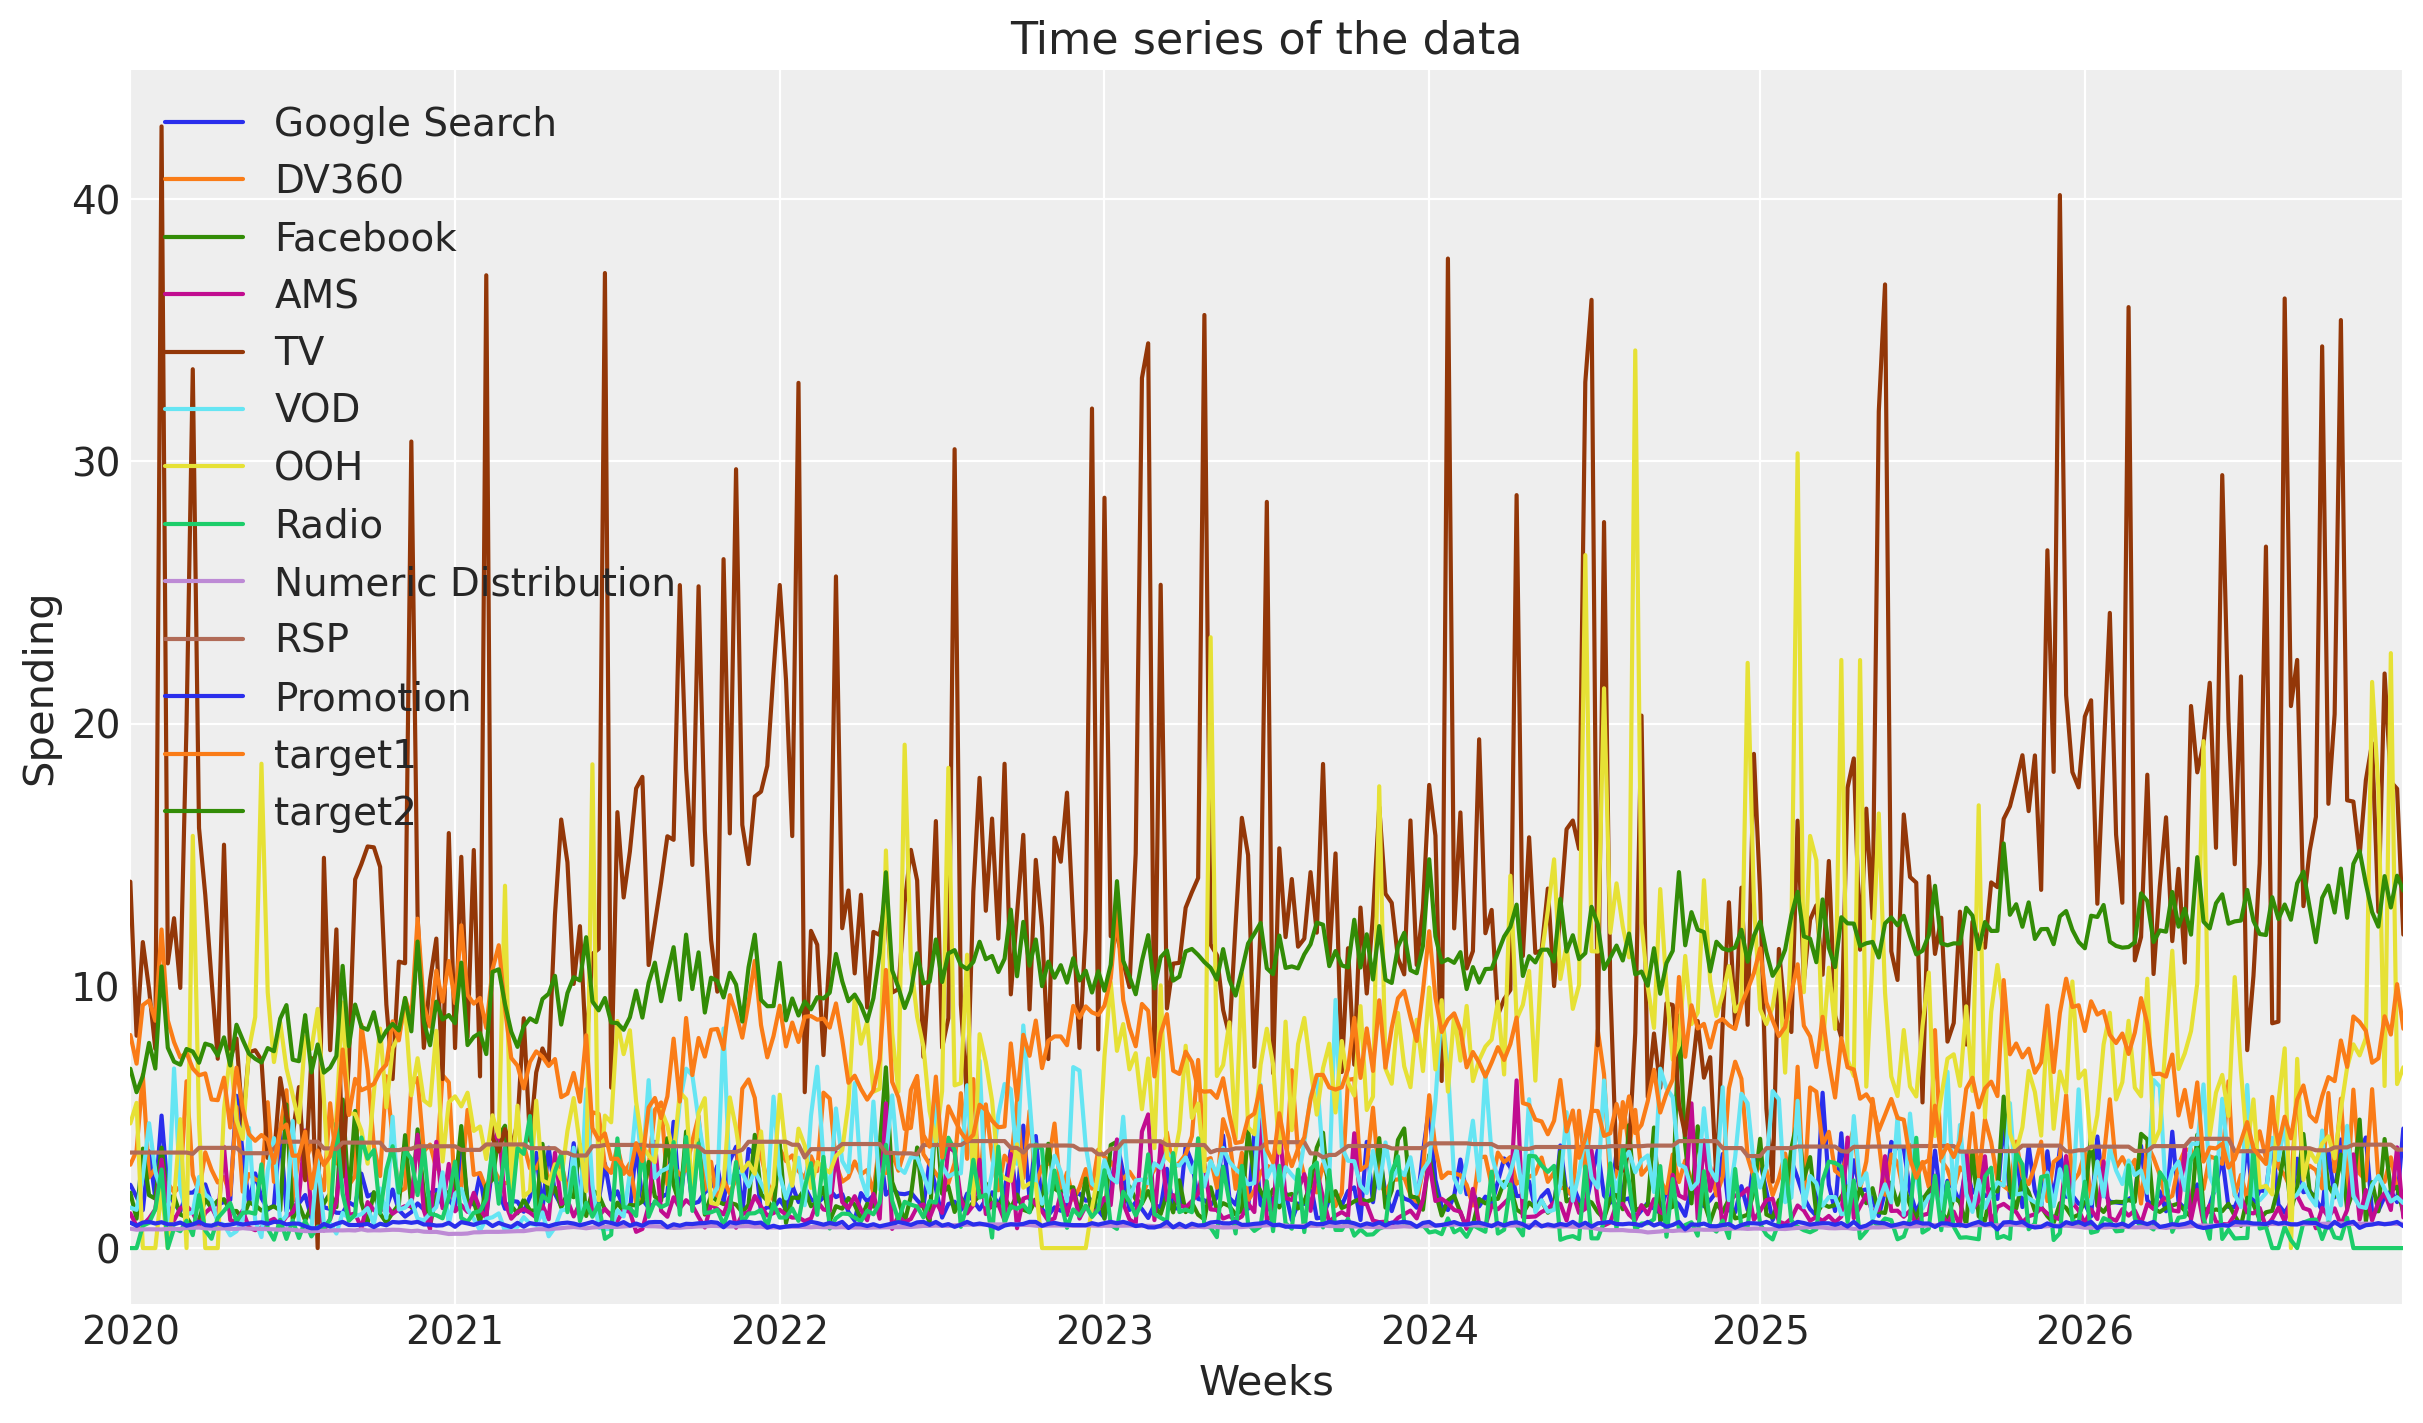

In [4]:
fig, ax = plt.subplots()
DATA.set_index('Weeks').plot(ax=ax)
ax.set_title('Time series of the data')
ax.set_ylabel('Spending');

## Example 1: Yearly seasonality

A common pattern in the sale of many consumer goods, is that sales are higher in the summer and lower in the winter, or reverse. In this example, we we will simulate sales that follow this pattern—by letting the synthetic intercept be a cosine wave—and then see if the model can recover this using a time-varying intercept.

#### → Simulate sales

The data we loaded did *not* have a target variable. Instead, we will simulate one, by **defining a model with fixed parameters**. This is something we can do using [the recently added `do` operator](https://www.pymc-labs.com/blog-posts/causal-analysis-with-pymc-answering-what-if-with-the-new-do-operator/) in `pymc`. If you haven't seen this trick before, take notes because it's powerful.

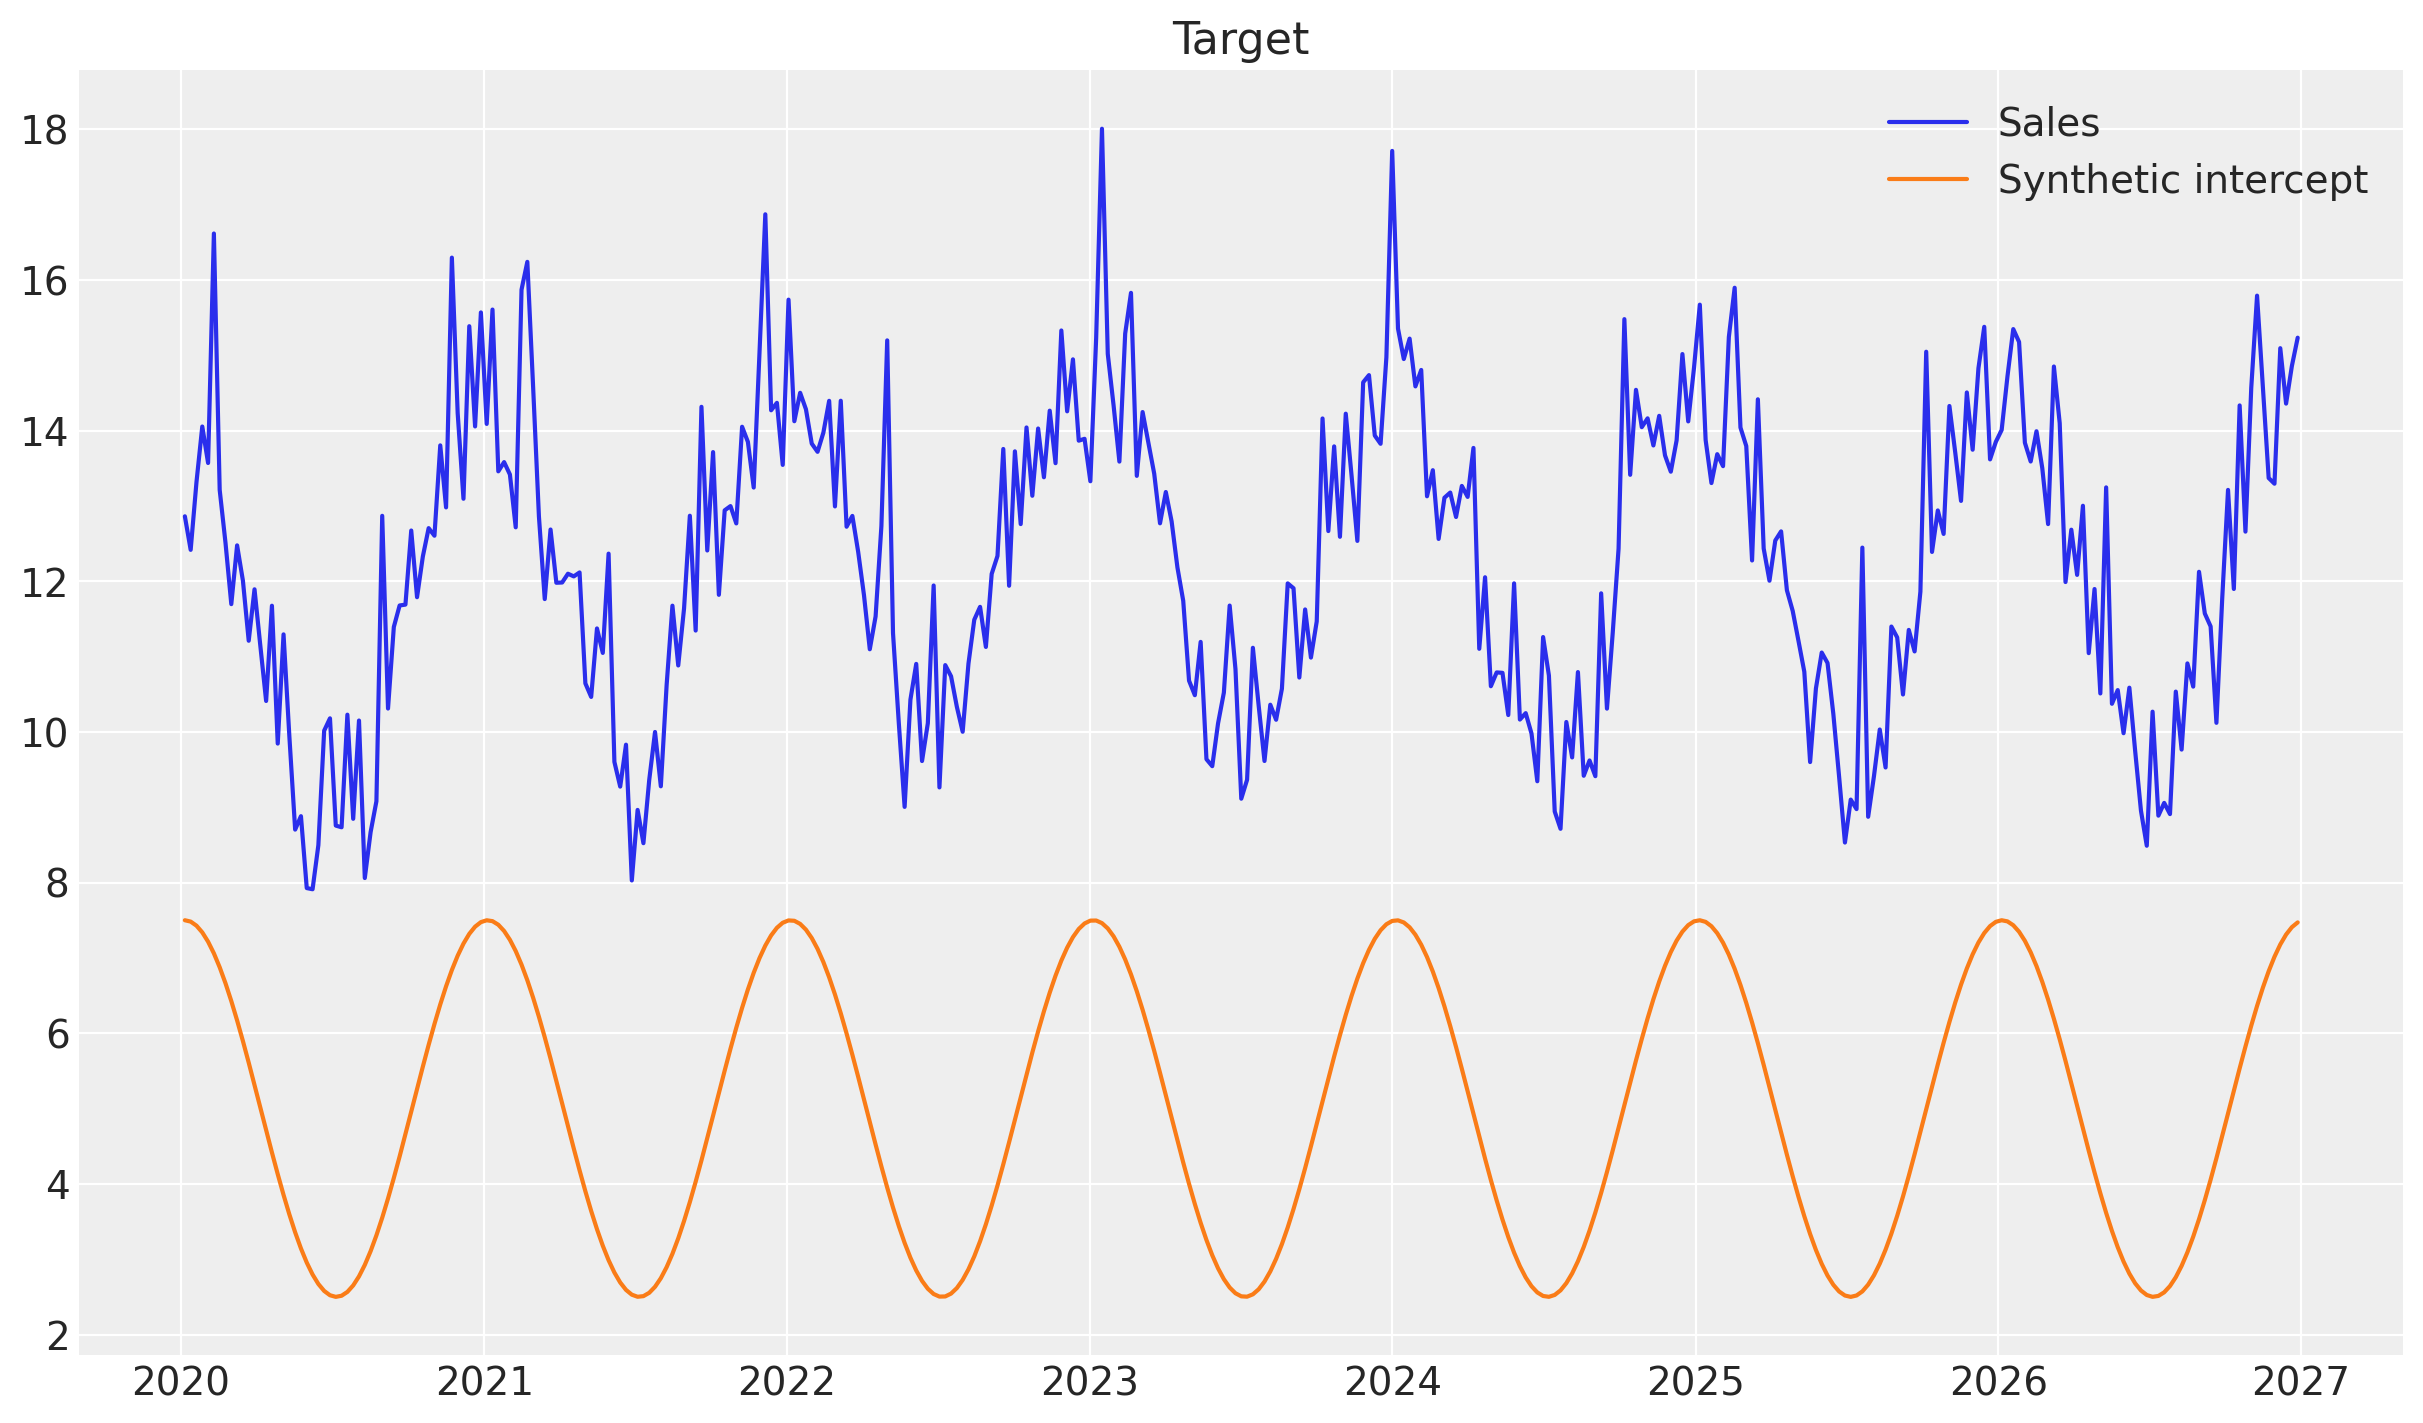

In [5]:
def synthesize_and_plot_target(synthetic_intercept: npt.NDArray) -> npt.NDArray:
    # Create the model, with channel spend, control variables, adstock, and yearly seasonality.
    # This model is **structurally identical** to the model we will fit a couple cells below.
    mmm_synth = DelayedSaturatedMMM(
        date_column="Weeks",
        channel_columns=COORDS["media"],
        control_columns=COORDS["control"],
        adstock_max_lag=10,
        time_varying_intercept=True,
    )

    mmm_synth.build_model(DATA, np.ones(DATA.shape[0]))

    # Synthetic model parameters. These are largely arbitrary, though chosen to be somewhat realistic.
    synthetic_params = {
        "intercept": synthetic_intercept,
        "beta_channel": np.array([3.5, 2.0, 5.0, 3.2, 1.5, 2.0, 1.0, 1.5]) * 4,
        "alpha": np.array([0, 0.5, 0.1, 0.1, 0.9, 0.5, 0.9, 0.95]),
        "lam": 1 / (DATA[COORDS["media"]].mean(0)).values,
        "likelihood_sigma": 0.25,
    }

    # Manually set the model parameters. The `do` operator returns a new model where the parameters
    # which were supplied are deterministic.
    true_model = pm.do(
        mmm_synth.model,
        synthetic_params,
    )

    # Draw the target series from the model
    target = pm.draw(true_model.y, random_seed=SEED)

    # Plot the simulated target series
    fig, ax = plt.subplots()
    ax.set_title("Target")
    ax.plot(DATA.Weeks, target, label="Sales")
    ax.plot(DATA.Weeks, synthetic_intercept, label="Synthetic intercept")
    ax.legend()

    return target


# Define a synthetic time-varying intercept. In this first example, we set the intercept
# to be a cosine wave with a period of 52.18 weeks (1 year) which oscilates around 5.
N = DATA.shape[0]
synthetic_intercept_seasonal = (
    np.cos(2 * np.pi / 52.18 * np.arange(N)) / 2 + 1
) * 5  # 👈 Intercept that oscilates around 5

DATA["target_seaonal"] = synthesize_and_plot_target(synthetic_intercept_seasonal)

#### → Split into train and test
We split the data into *train* and *test* sets, so that we can later display out-of-sample predictive performance.

In [6]:
SPLIT_N = 52
data_train = DATA.iloc[:-SPLIT_N]
data_test = DATA.iloc[-SPLIT_N:]

#### → Fit model

In [7]:
def create_and_fit_MMM(data: pd.DataFrame, target: pd.Series) -> DelayedSaturatedMMM:
    mmm = DelayedSaturatedMMM(
        date_column="Weeks",
        channel_columns=COORDS["media"],
        control_columns=COORDS["control"],
        adstock_max_lag=10,
        time_varying_intercept=True,
        sampler_config={
            "chains": 4,
            "draws": 4000,
            "tune": 1000,
            "nuts_sampler": "numpyro",
        },
    )
    mmm.fit(data, target)
    return mmm


mmm_seasonal = create_and_fit_MMM(data_train, data_train["target_seaonal"])

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


#### → Posterior predictive checks

To get a sense of how well the model fits the data we can visualize the posterior predictive distribution.

**Sales**

We first visualize predicted and actual sales, both within- and out-of-sample.

Some observations:

* The model performs well in-sample.
* ~3 months into the out-of-sample set, predictions deviate from the trend.
  

Sampling: [y]


Output()

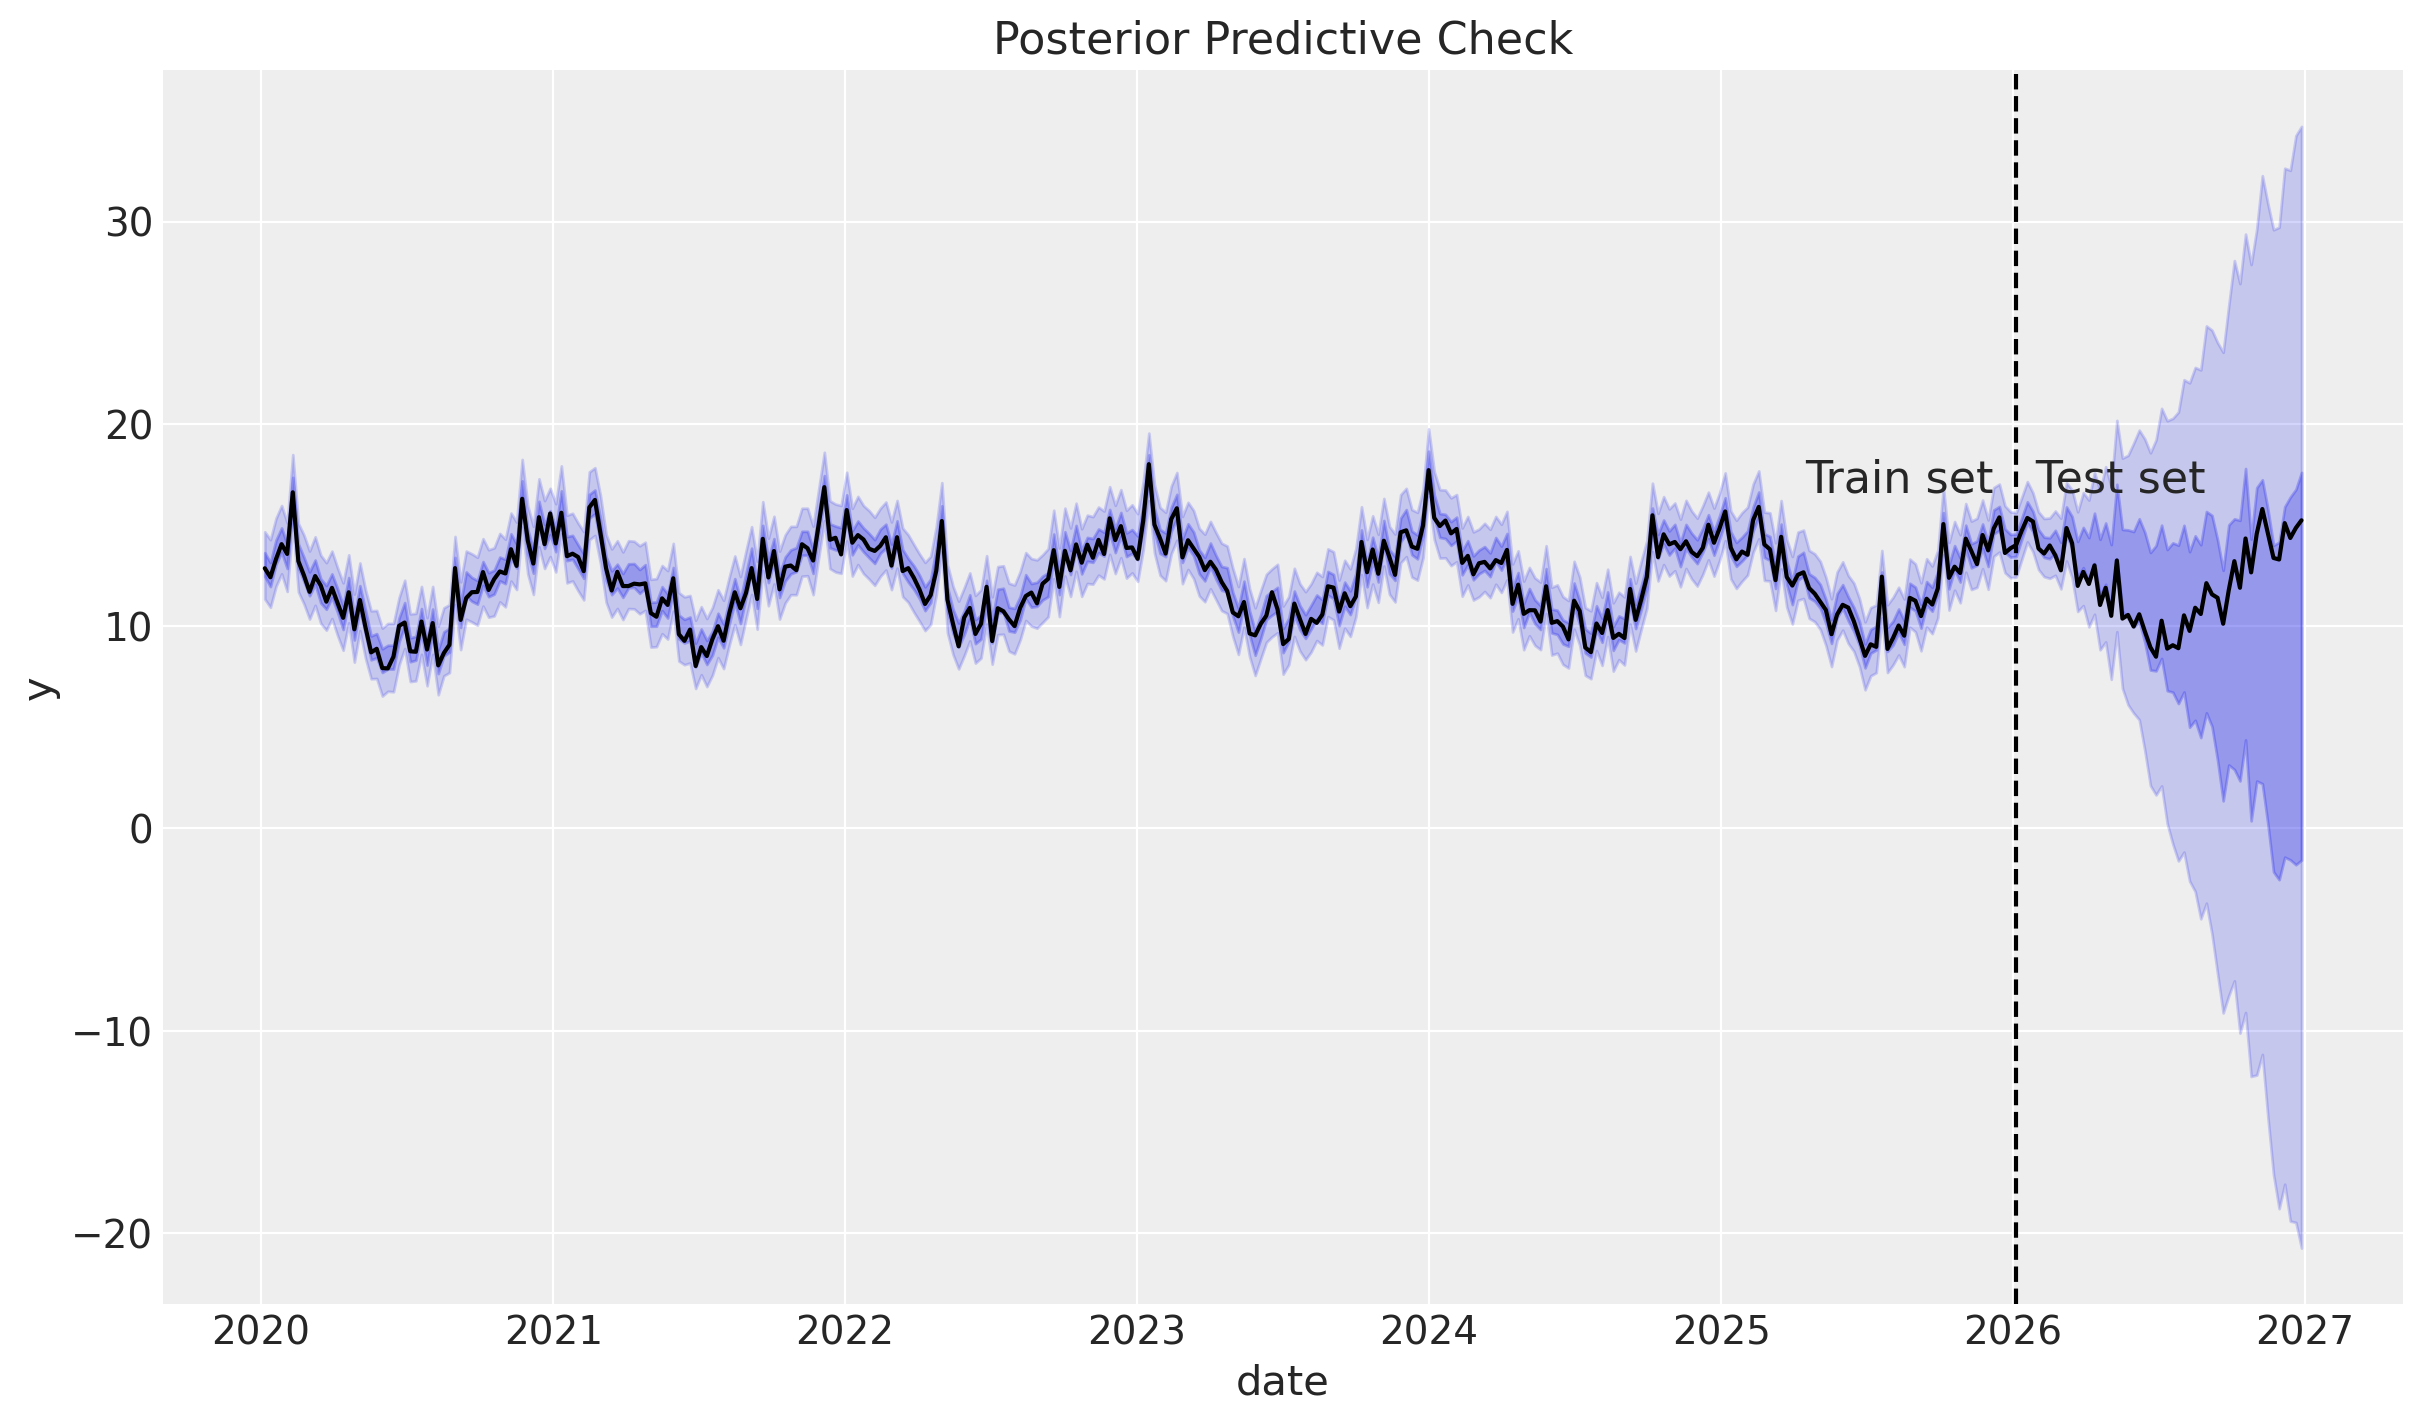

In [8]:
def plot_posterior_predictive(
    mmm: DelayedSaturatedMMM,
    target_series: pd.Series,
    ylim: tuple[int, int] | None = None,
):
    # Sample posterior predictive in whole data range (train and test)
    mmm.sample_posterior_predictive(
        X_pred=DATA, extend_idata=True, var_names=["y", "intercept"]
    )
    mmm.y = target_series.values

    # Plot the posterior predictive
    fig, ax = plt.subplots()
    if ylim is not None:
        ax.set_ylim(ylim)
    mmm.plot_posterior_predictive(original_scale=True, ax=ax)
    split_index = DATA.shape[0] - SPLIT_N
    ax.axvline(
        mmm.posterior_predictive.date[split_index].values,
        color="black",
        linestyle="--",
    )
    ax.text(
        mmm.posterior_predictive.date[split_index].values - int(14 * 864000e8),
        mmm.target_transformer.inverse_transform(
            [[np.percentile(mmm.posterior_predictive.y, 97.5)]]
        )[0][0],
        "Train set   Test set",
        verticalalignment="center",
        horizontalalignment="center",
        fontsize=16,
    )


plot_posterior_predictive(mmm_seasonal, DATA["target_seaonal"])

**Predicting intercept**

We can dig one step deeper, and display the posterior predictive distribution of the time-varying intercept.

Visualizing this, it's clear that:

* In-sample it gets the synthetic trend right!
* Out-of-sample, the GP starts reverting to its prior mean of *one* $\times$ the baseline intercept of 5, which the model infers to:

In [9]:
def print_intercept_base(mmm):
    print(
        "intercept_base:",
        float(
            mmm.idata.posterior.intercept_base.mean()
            * mmm.target_transformer.steps[0][1].scale_[0]
        ),
    )


print_intercept_base(mmm_seasonal)

intercept_base: 4.671336279835101


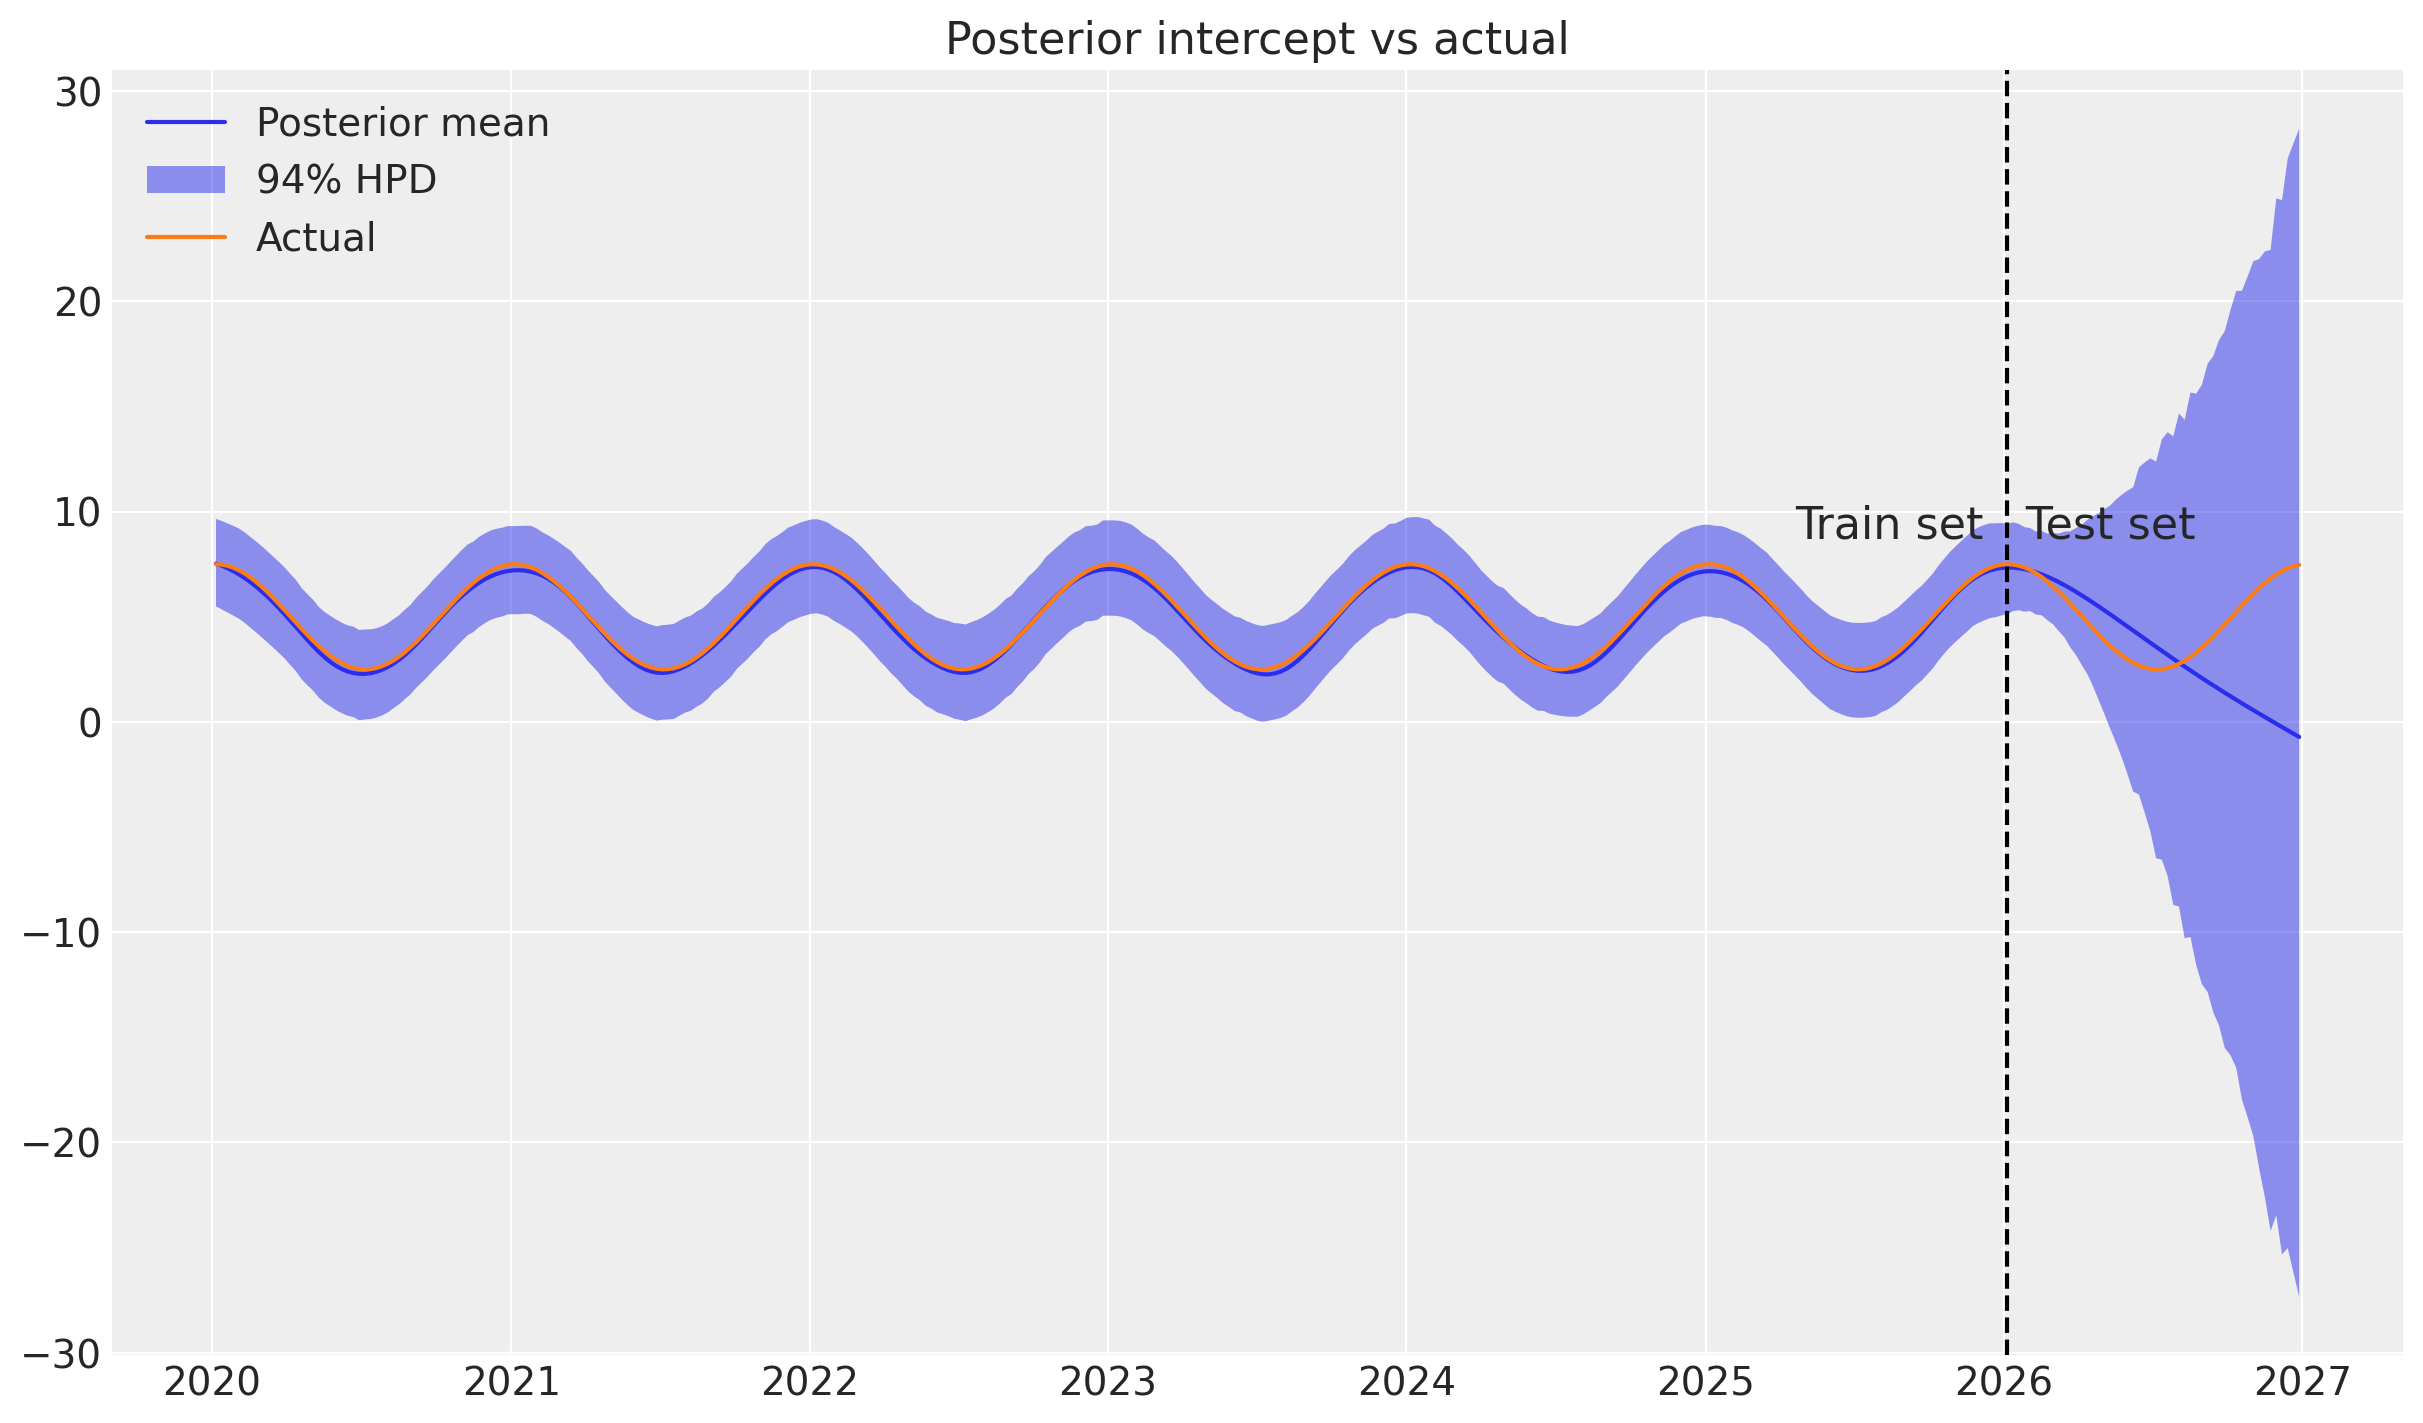

In [10]:
def plot_intercept_posterior_predictive(mmm, synthetic_intercept):
    # Get the posterior predictive of intercept
    intercept_posterior_mean = mmm.target_transformer.inverse_transform(
        mmm.posterior_predictive.intercept.mean(axis=(0, 1)).data[:, None]
    )
    intercept_posterior_hpd = mmm.target_transformer.inverse_transform(
        az.hdi(mmm.posterior_predictive.intercept.values, hdi_prob=0.94)
    )

    # Plot posterior intercept versus actual
    fig, ax = plt.subplots()
    ax.set_title("Posterior intercept vs actual")
    ax.plot(mmm.posterior_predictive.date, intercept_posterior_mean, label="Posterior mean")
    ax.fill_between(
        mmm.posterior_predictive.date,
        intercept_posterior_hpd[:, 0],
        intercept_posterior_hpd[:, 1],
        alpha=0.5,
        label="94% HPD",
    )
    ax.plot(mmm.posterior_predictive.date, synthetic_intercept, label="Actual")
    split_index = DATA.shape[0] - SPLIT_N
    ax.axvline(
        mmm.posterior_predictive.date[split_index].values,
        color="black",
        linestyle="--",
    )
    ax.text(
        mmm.posterior_predictive.date[split_index].values - int(14 * 864000e8),
        mmm.target_transformer.inverse_transform([[np.percentile(mmm.posterior_predictive.intercept, 97.5)]])[0][0],
        "Train set   Test set",
        verticalalignment="center",
        horizontalalignment="center",
        fontsize=16,
    )
    ax.legend()


plot_intercept_posterior_predictive(mmm_seasonal, synthetic_intercept_seasonal)

## Example 2: Upward trending sales
This section repeats the steps above, except with a linearly increasing intercept with mean 2.5, to mimics upward trending sales.

#### → Simulate sales

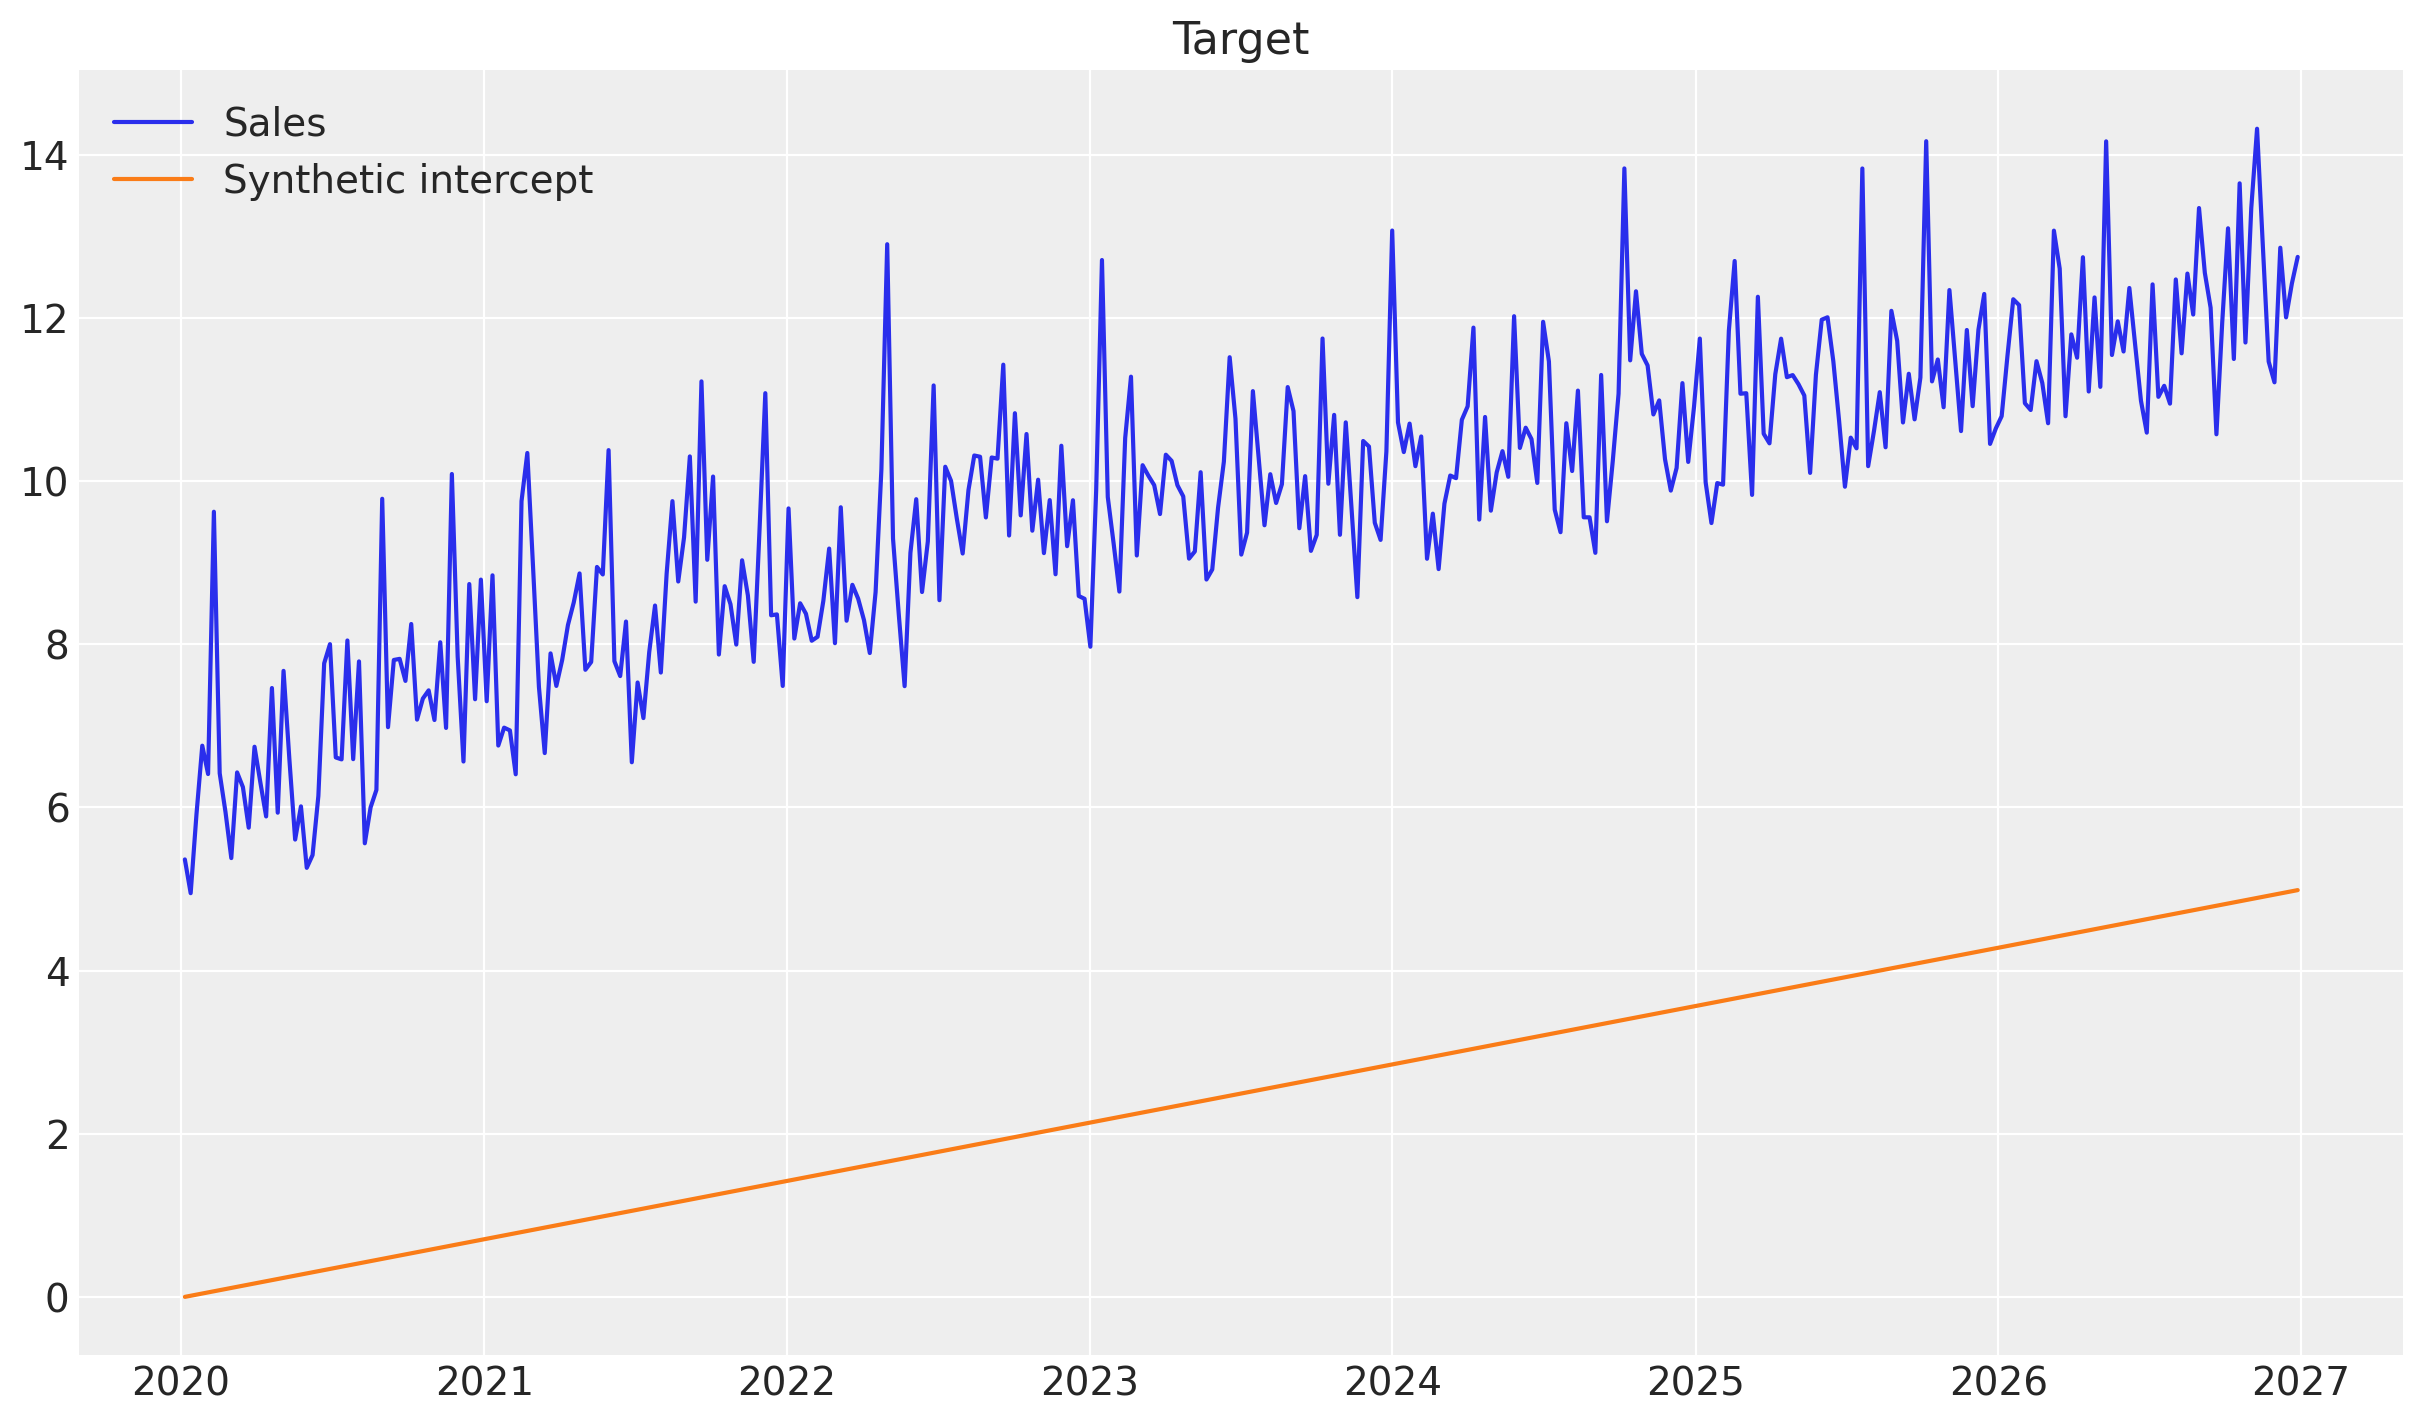

In [11]:
N = DATA.shape[0]
synthetic_intercept_upwards = np.arange(N) / N * 5

DATA["target_upwards"] = synthesize_and_plot_target(synthetic_intercept_upwards)

#### → Split into train and test

In [12]:
data_train = DATA.iloc[:-SPLIT_N]
data_test = DATA.iloc[-SPLIT_N:]

#### → Fit model

In [13]:
mmm_upwards = create_and_fit_MMM(data_train, data_train["target_upwards"])

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


#### → Posterior predictive check

**Predicting sales**

Observations:

* The model performs well in-sample.
* ~3 months into the out-of-sample set, predictions no longer follow the trend (same as in previous example).


Sampling: [y]


Output()

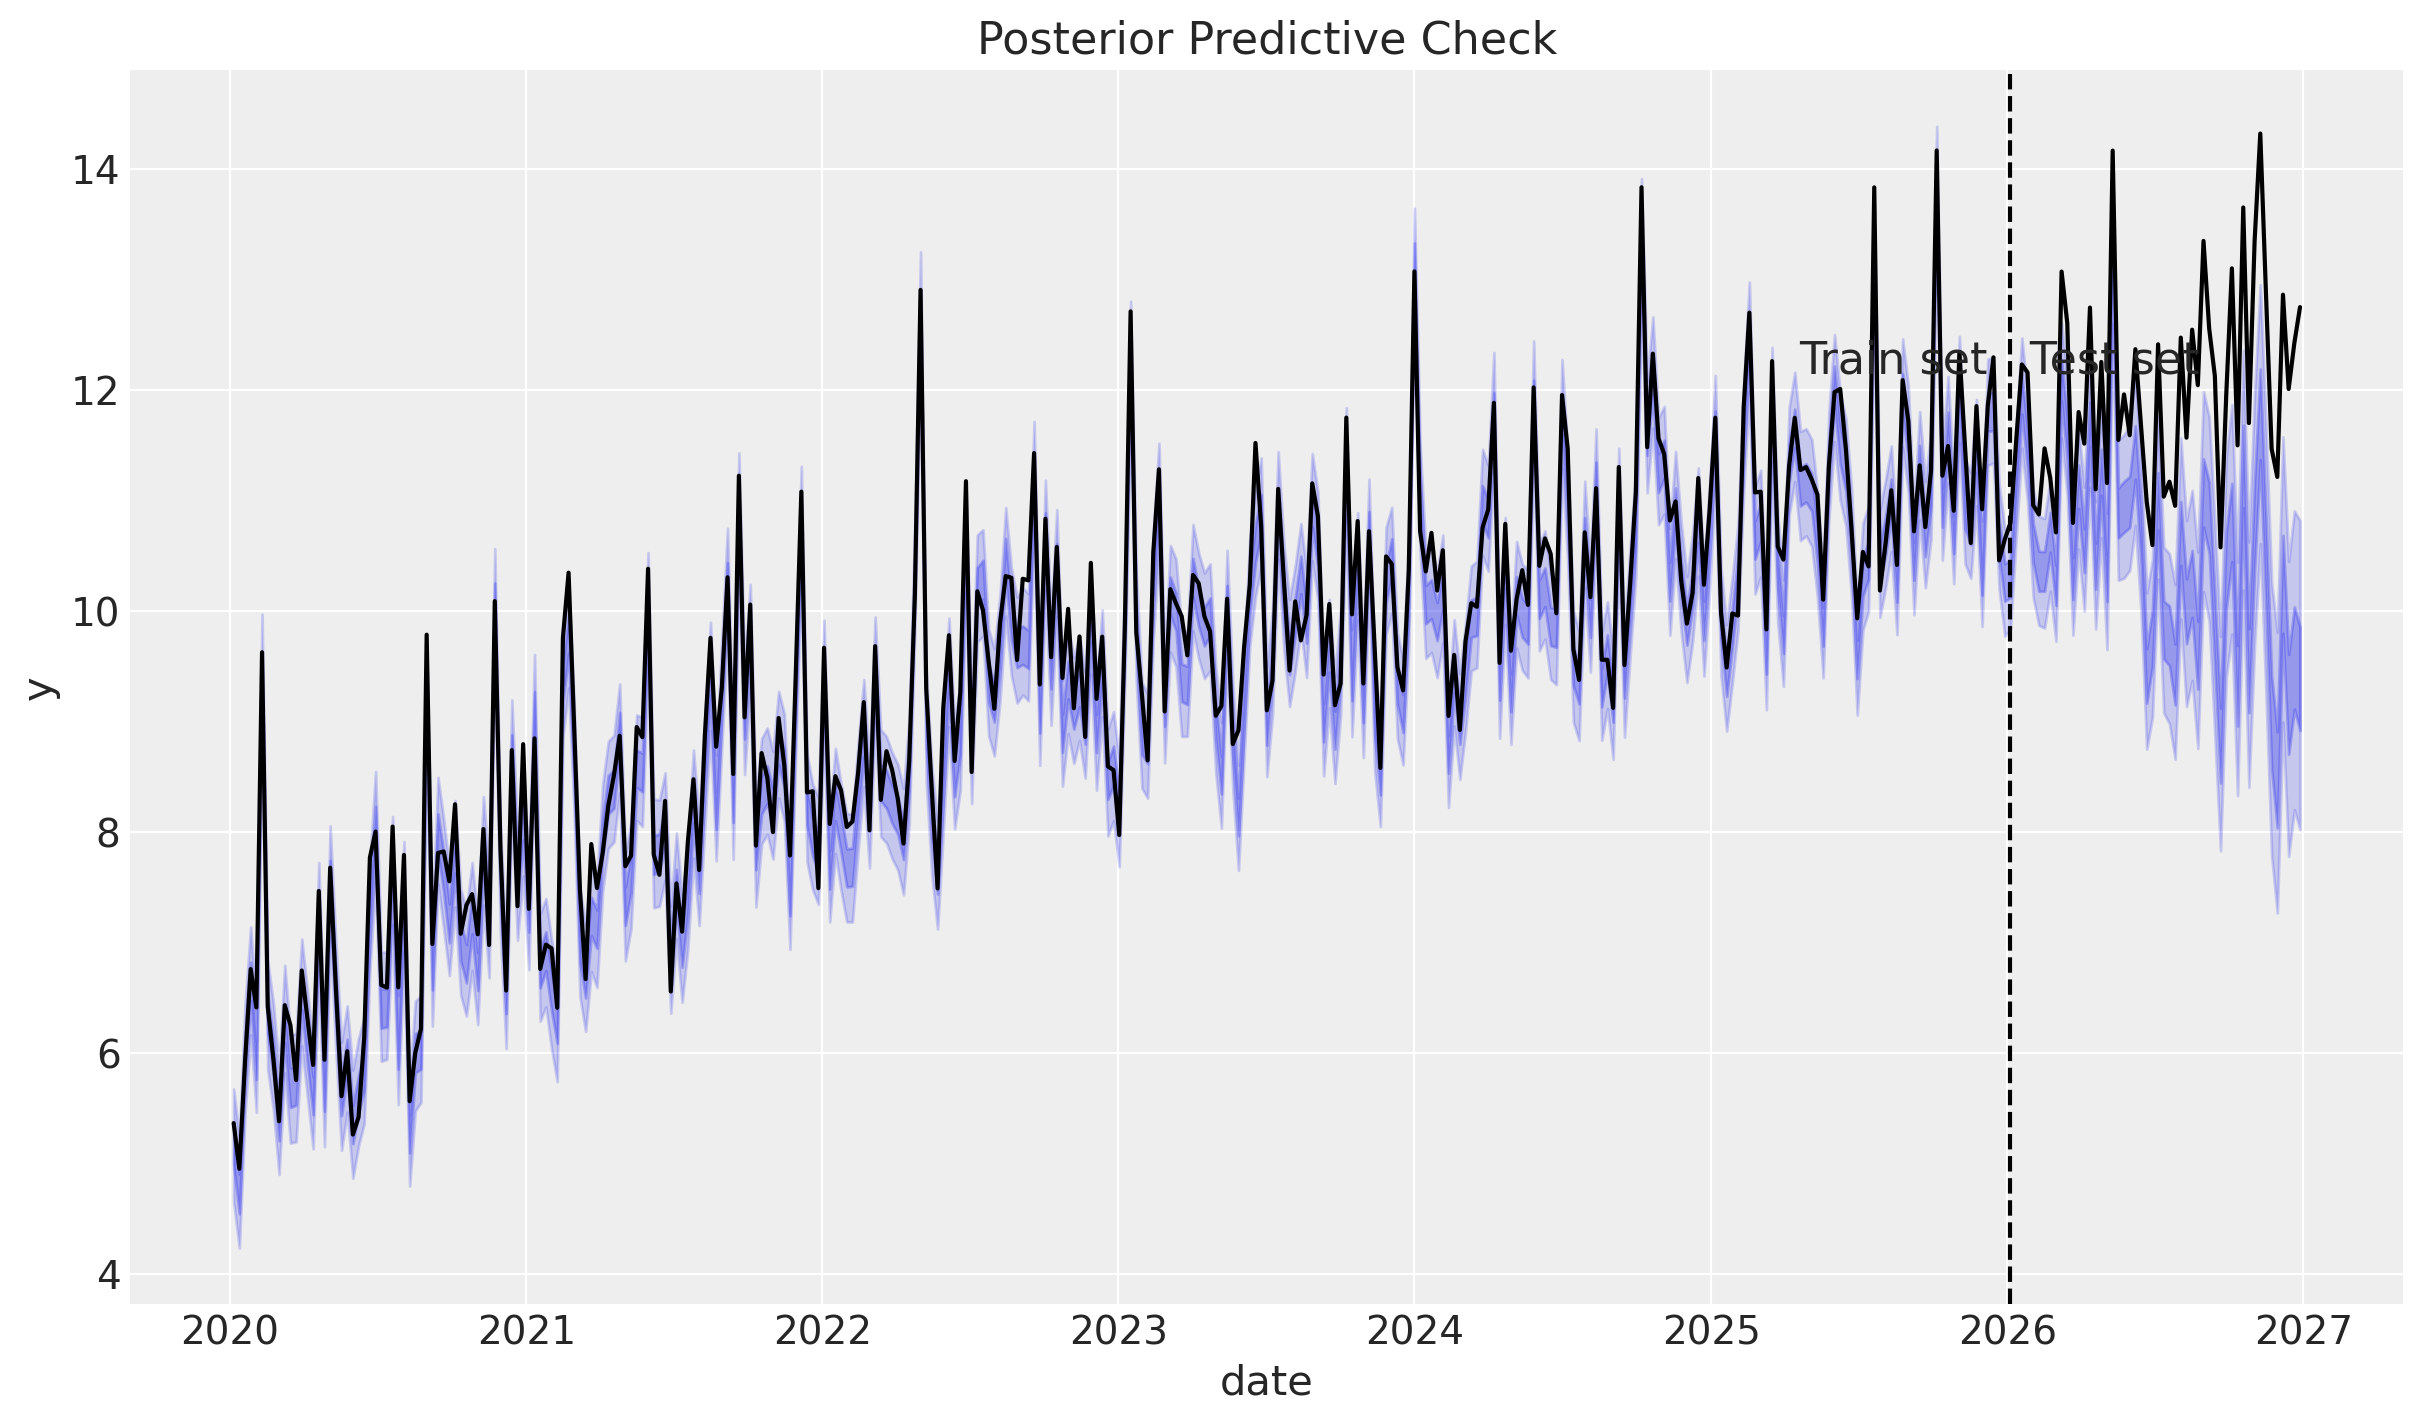

In [14]:
plot_posterior_predictive(mmm_upwards, DATA["target_upwards"])

**Predicting intercept**

Observations:

* In-sample it follows the synthetic trend quite well.
* Out-of-sample, the GP reverts the its prior mean of one $\times$ the baseline intercept, which was set to 2.5, and the model infers to:

In [15]:
print_intercept_base(mmm_upwards)

intercept_base: 0.5811329324055781


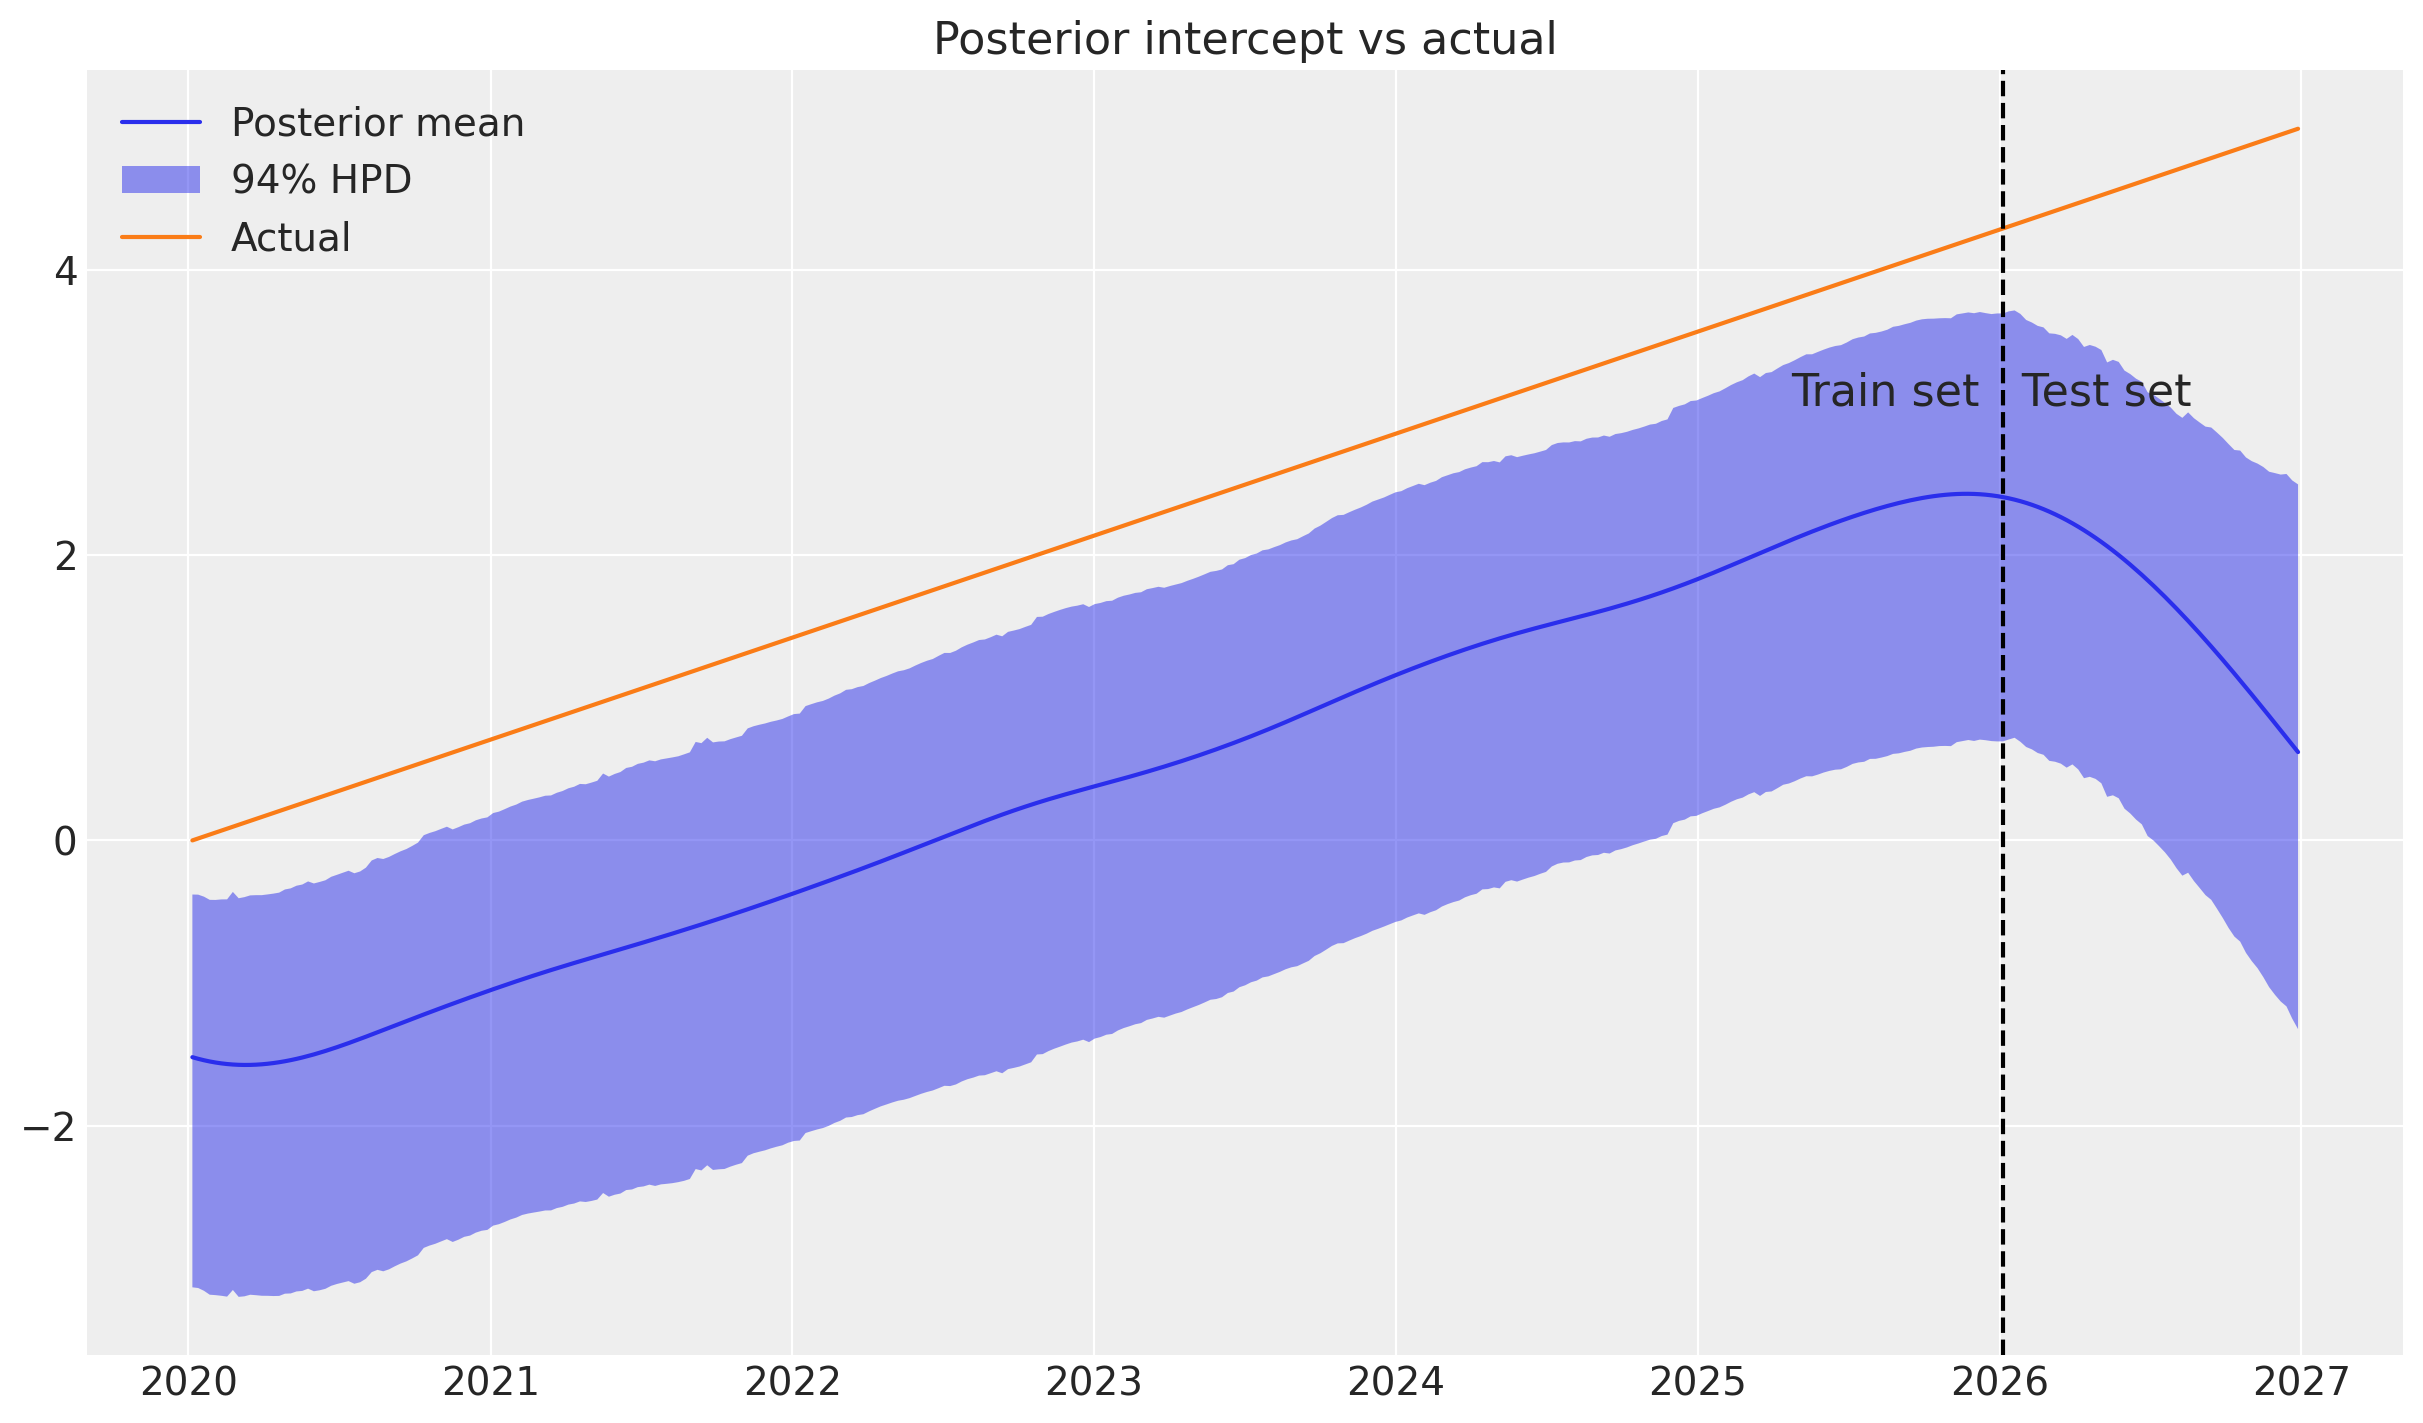

In [16]:
plot_intercept_posterior_predictive(mmm_upwards, synthetic_intercept_upwards)

## Example 3: Unexpected events

This section repeats the procedure but with an intercept that is 5, except with intermittent spike/dip events. Each such event, could be a product launch, a new competitor entering the market, a global pandemic, a unusually sunny spring, etc.

#### → Simulate sales

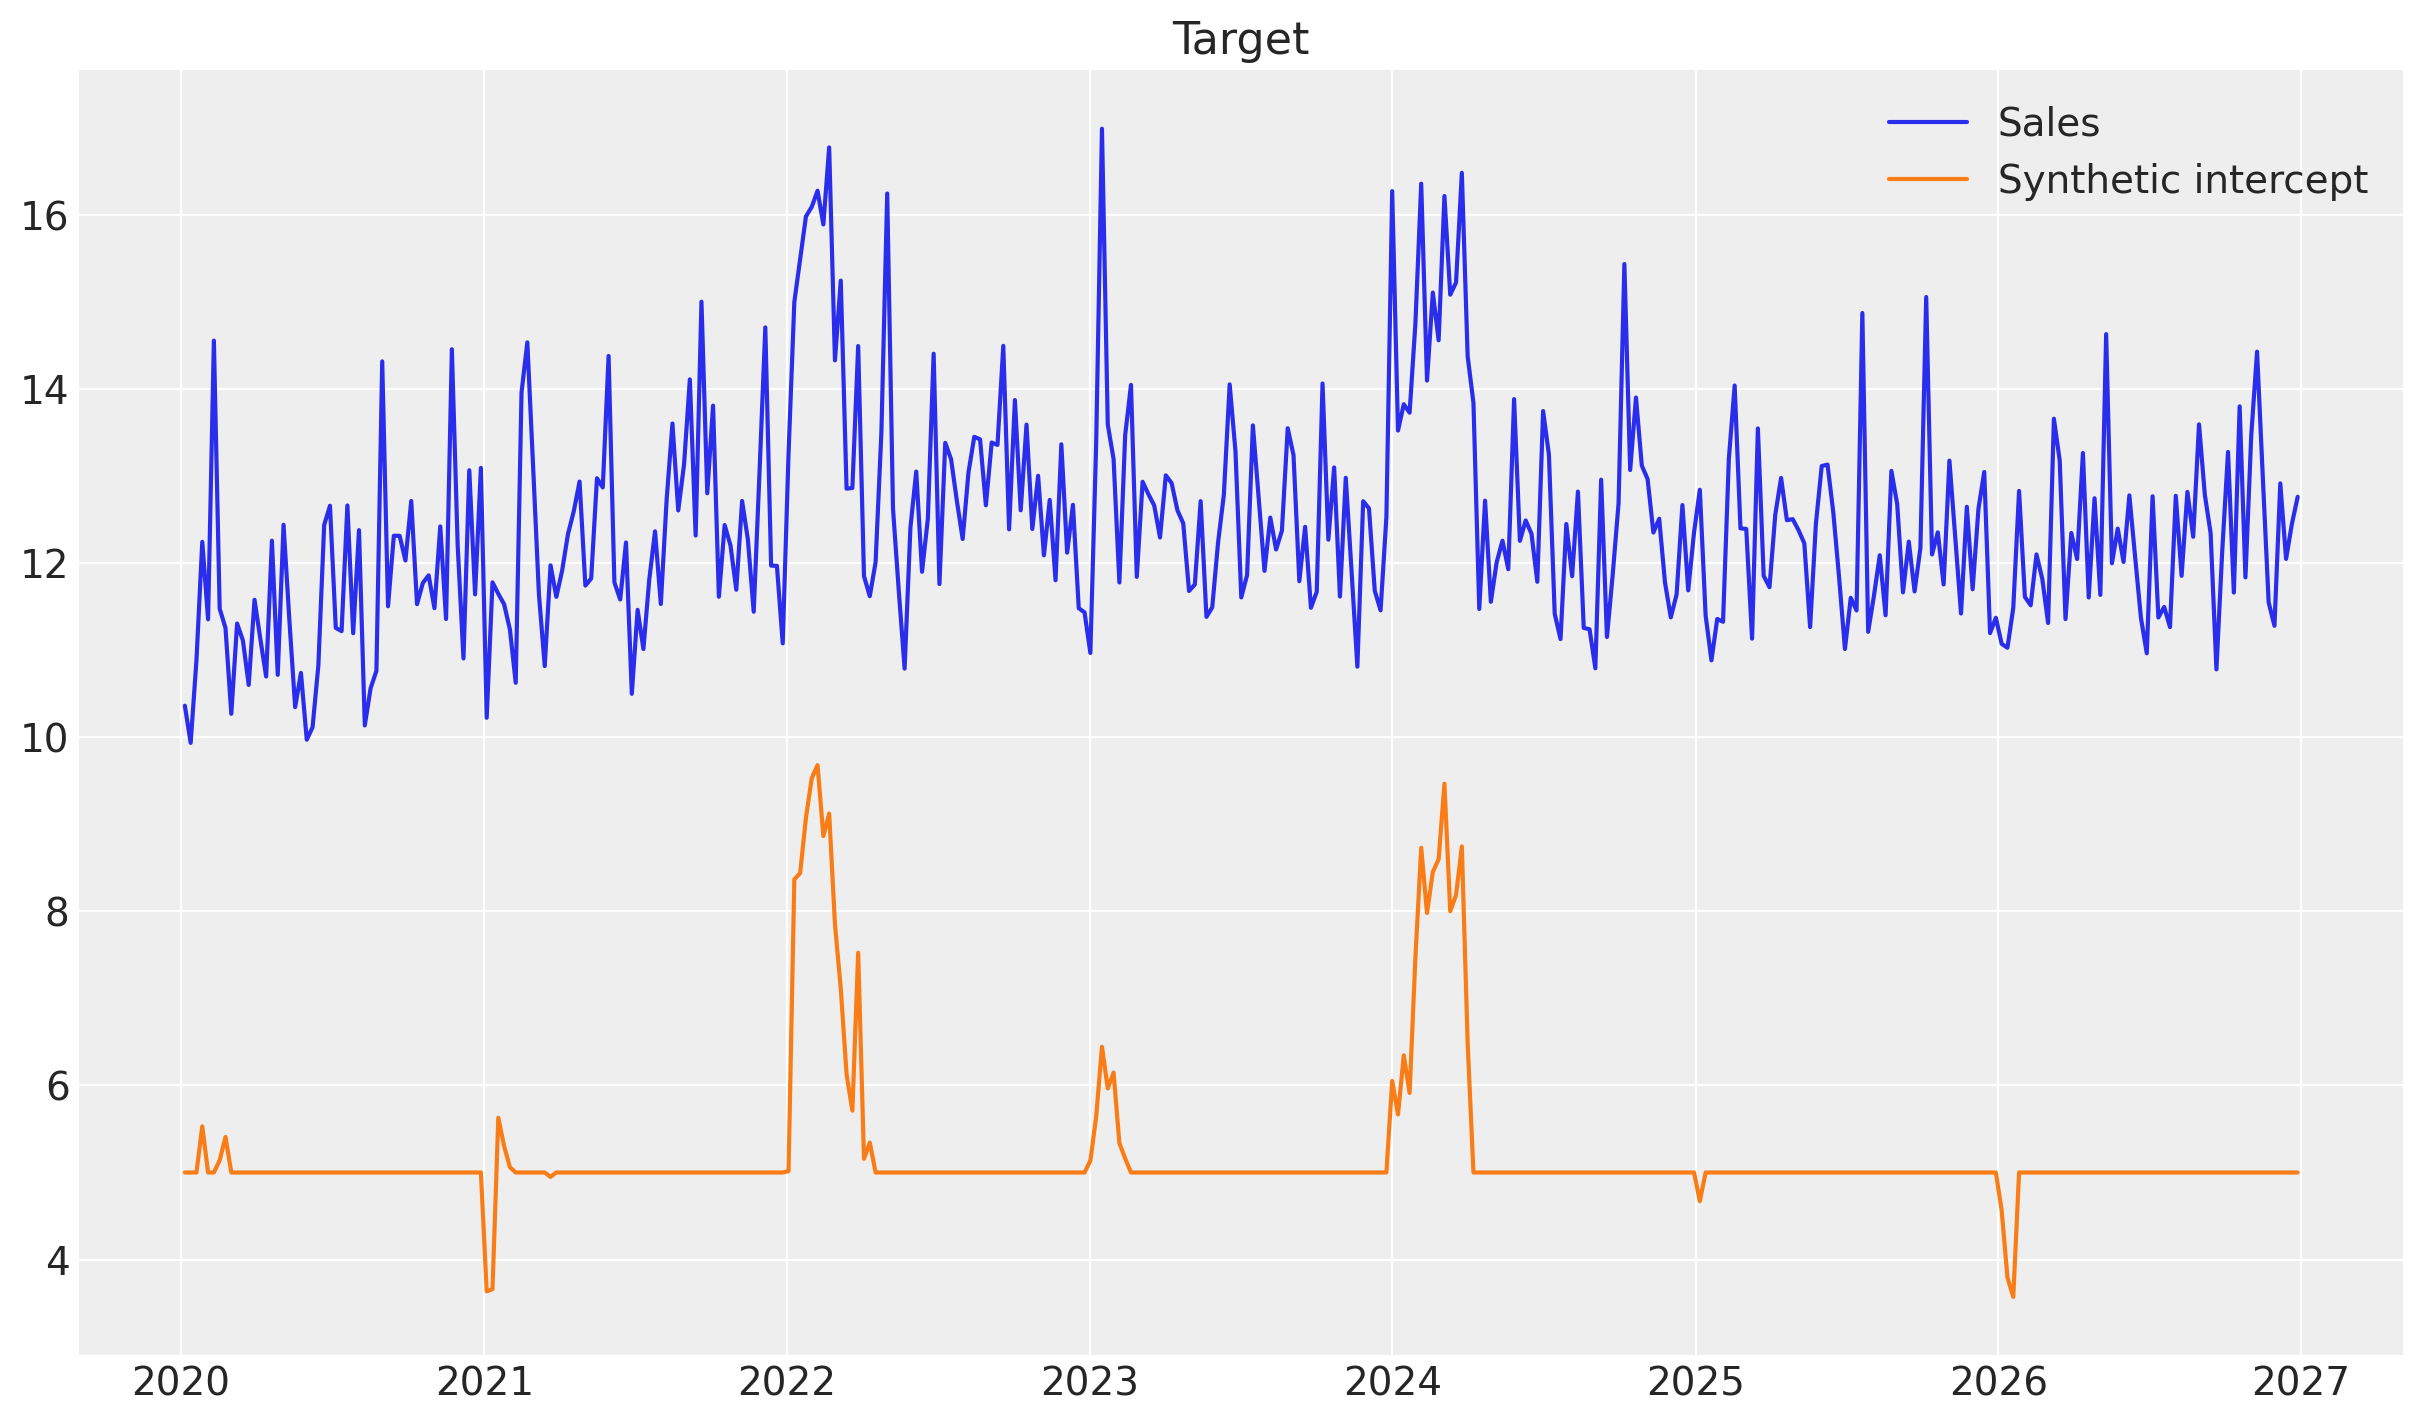

In [17]:
def create_yearly_series() -> npt.NDArray:
    np.random.seed(42)

    # Get the number of weeks in each year
    weeks_in_years = DATA.Weeks.dt.year.value_counts().sort_index()

    # Create a flat and occasionally spiky time-series, in one-year increments
    series = np.zeros(sum(weeks_in_years))
    for i, num_weeks in enumerate(weeks_in_years):
        # Random spikes in sales
        series[sum(weeks_in_years[:i]) : sum(weeks_in_years[: i + 1])] = (
            (np.random.normal(size=num_weeks) - 0.5).cumsum().clip(0)
        )
        # Random dips in sales
        series[sum(weeks_in_years[:i]) : sum(weeks_in_years[: i + 1])] += -(
            (np.random.normal(size=num_weeks) - 0.5).cumsum().clip(0)
        )
    return series


synthetic_intercept_events = create_yearly_series() + 5

DATA["target_events"] = synthesize_and_plot_target(synthetic_intercept_events)

#### → Split into train and test

In [18]:
data_train = DATA.iloc[:-SPLIT_N]
data_test = DATA.iloc[-SPLIT_N:]

#### → Fit model

In [19]:
mmm_events = create_and_fit_MMM(data_train, data_train["target_events"])

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


#### → Posterior predictive check

**Predicting sales**

Some observations:

* The model performs well in-sample.
* ~3 months into the out-of-sample set, uncertainty grows very high.

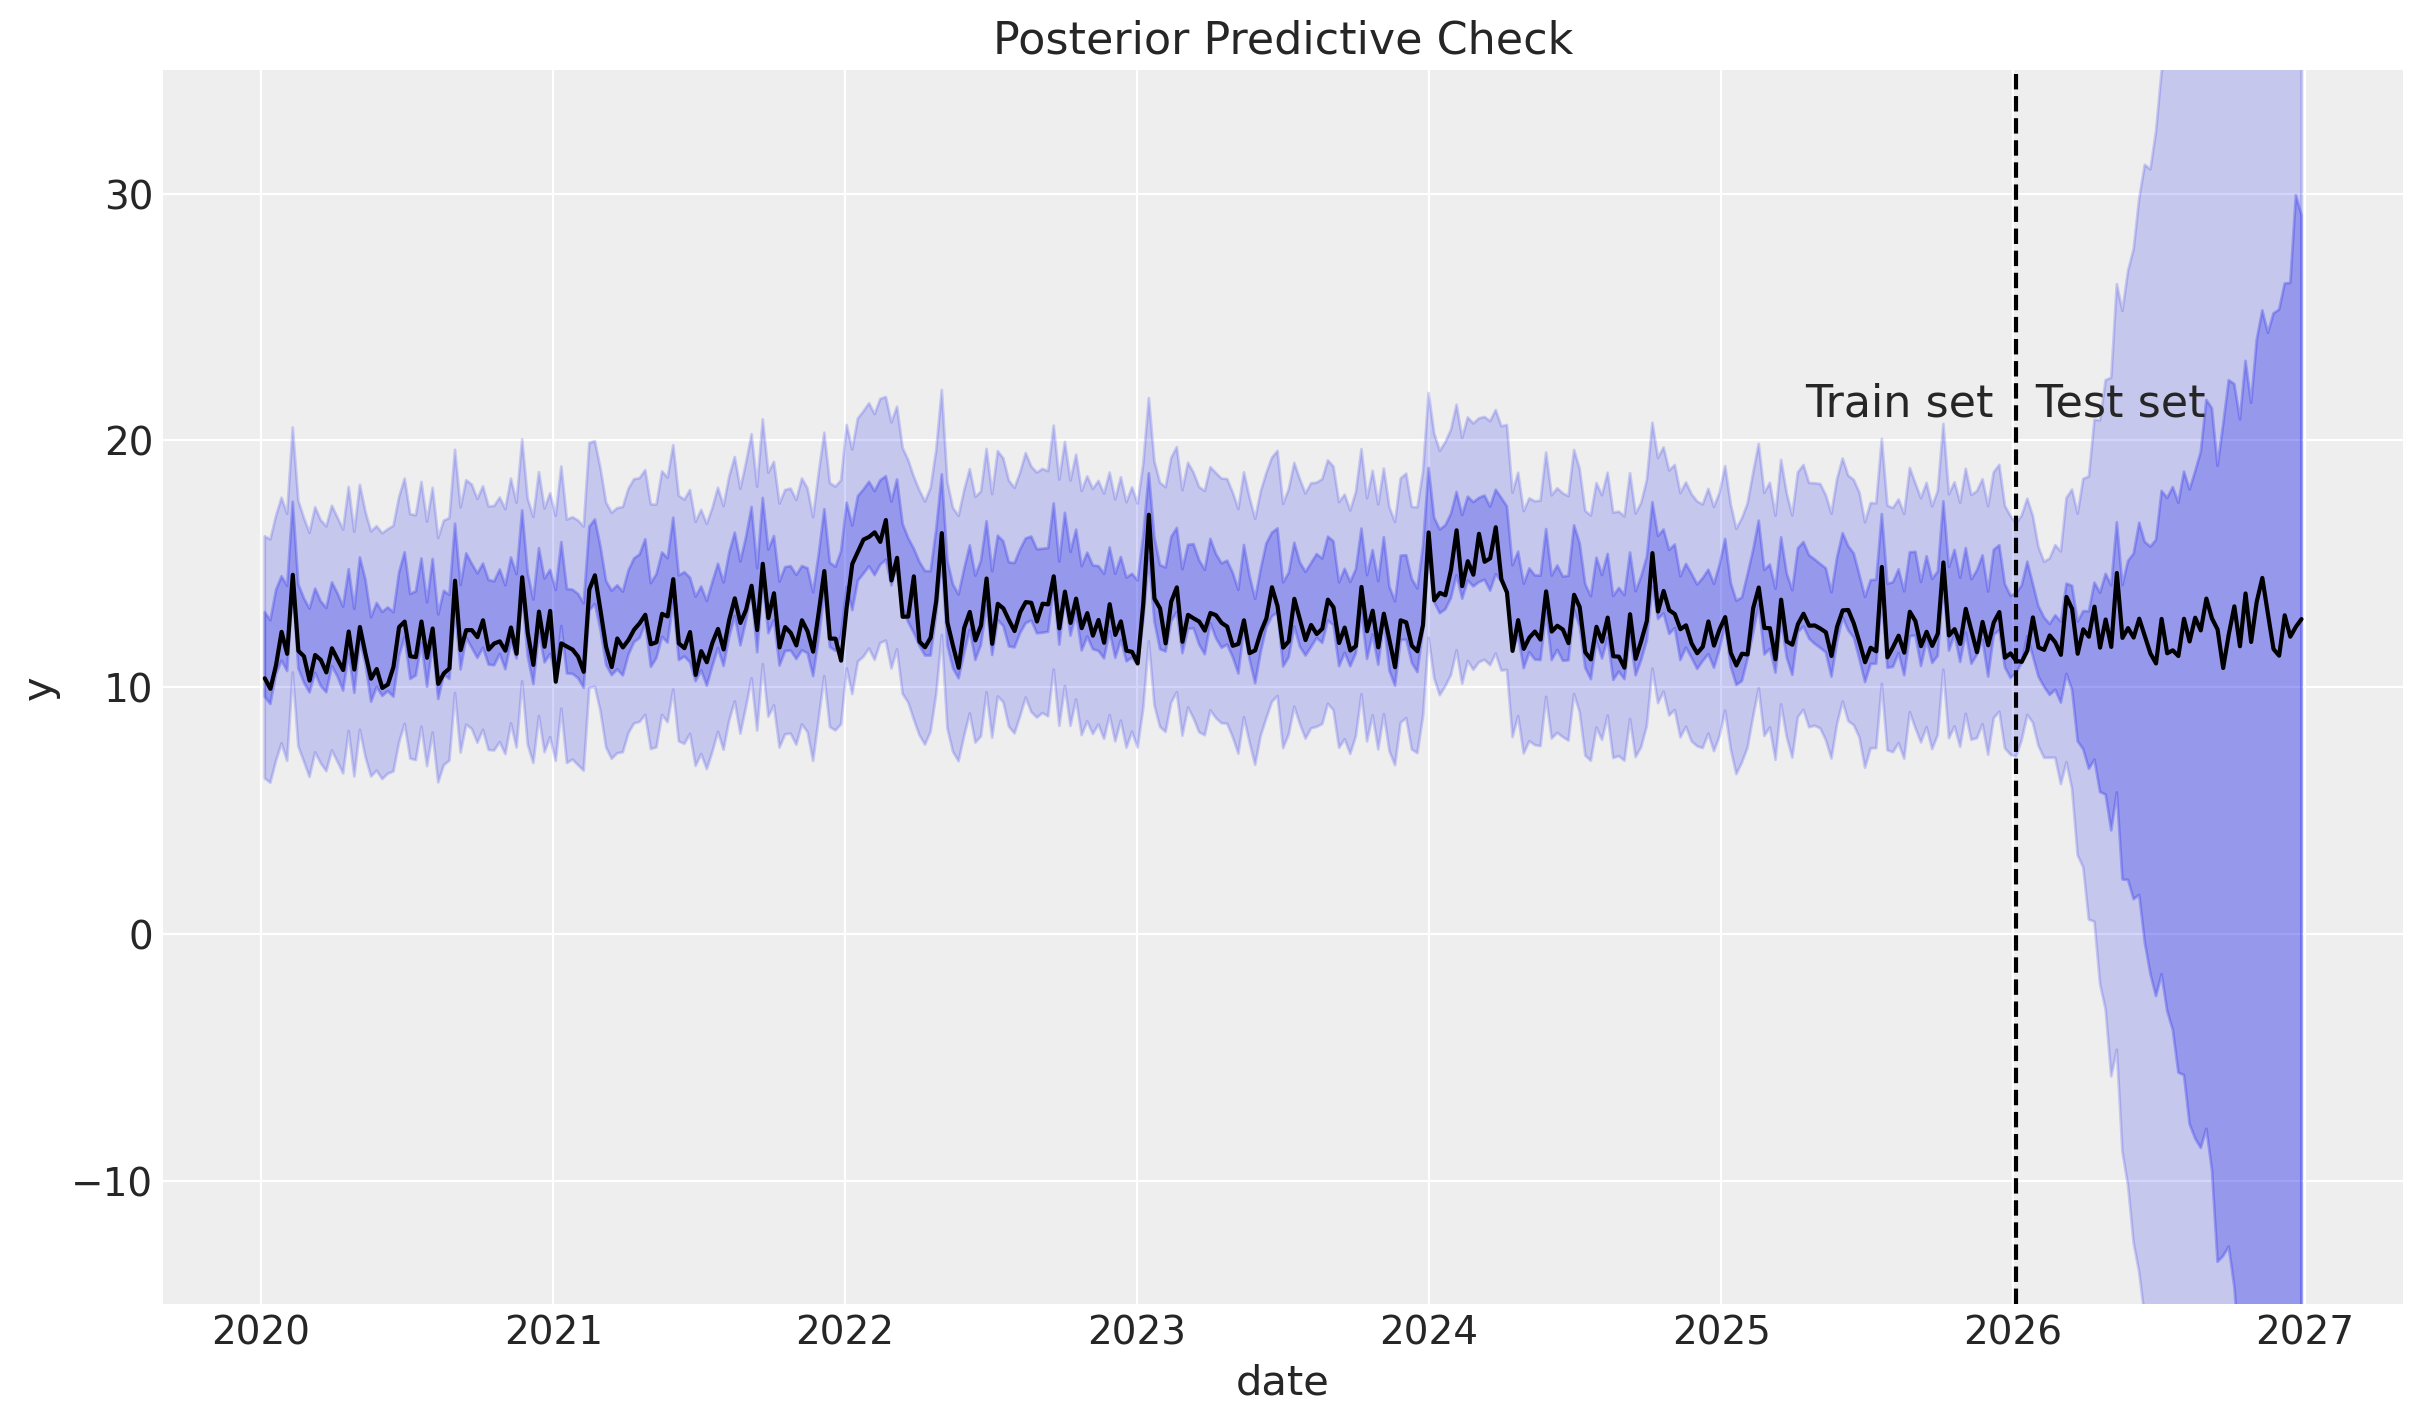

In [33]:
plot_posterior_predictive(mmm_events, DATA["target_events"], ylim=(-15, 35))

**Predicting intercept**

In [29]:
print_intercept_base(mmm_events)

intercept_base: 0.26783453308046634


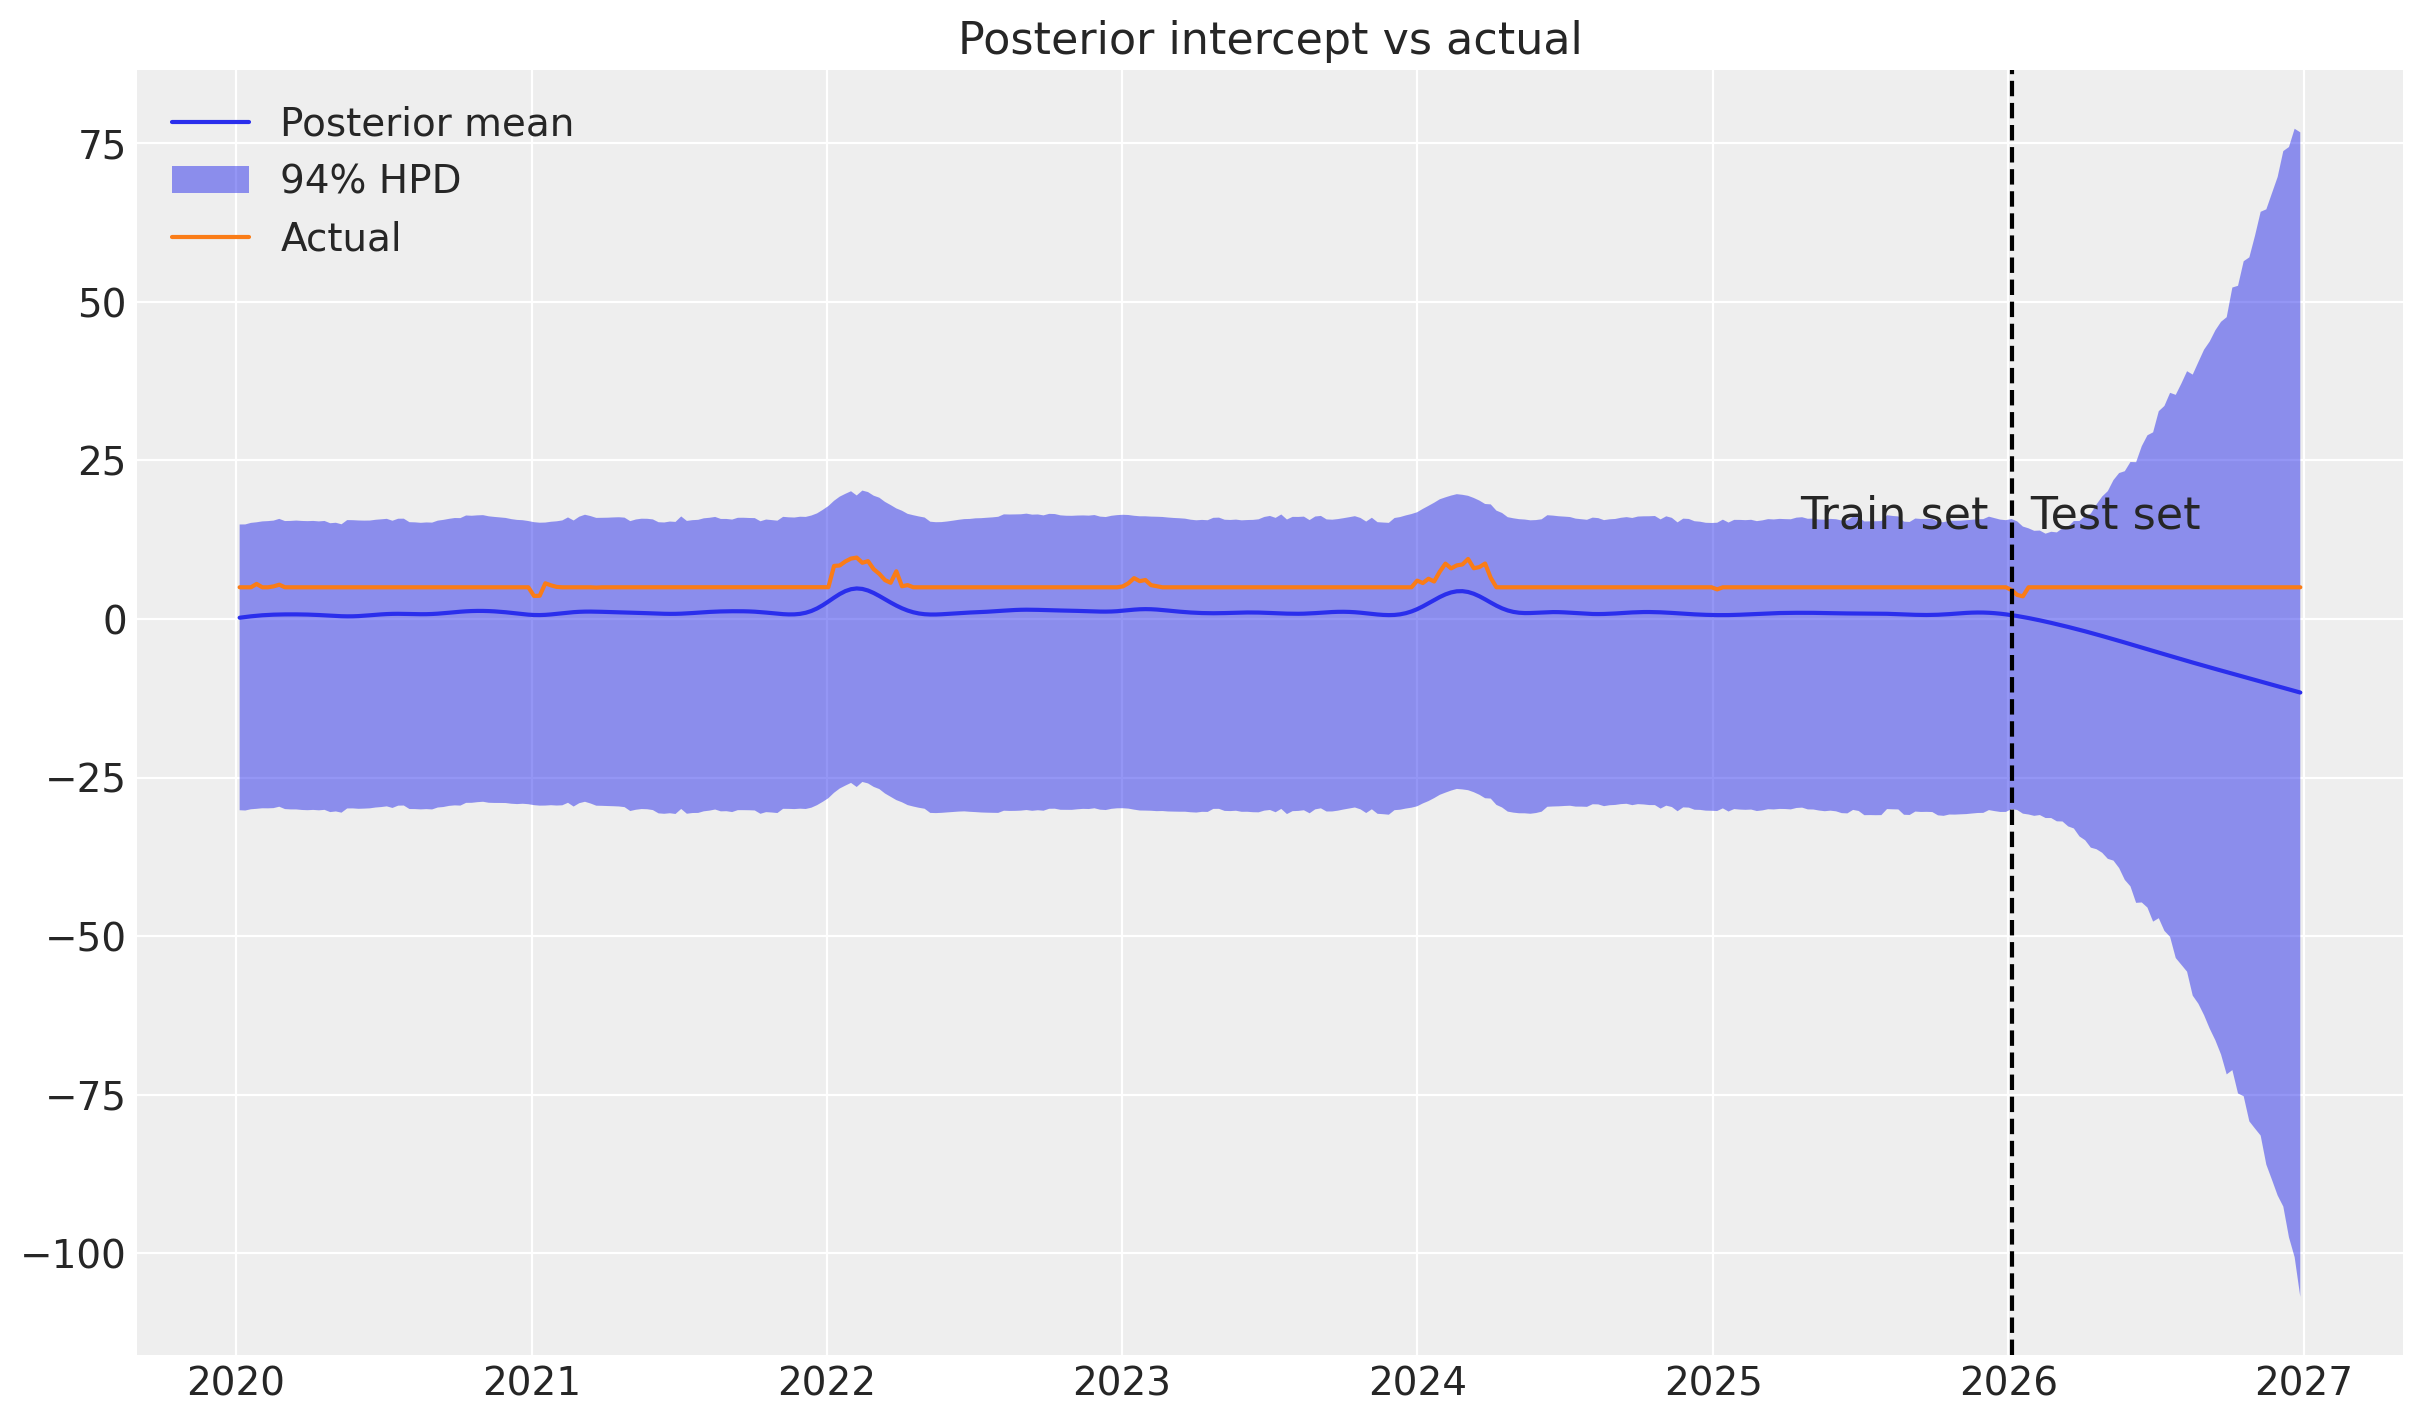

In [30]:
plot_intercept_posterior_predictive(mmm_events, synthetic_intercept_events)

Observations:

* Greater uncertainty than in the previous examples.
* Only the two major events are captured by the time-varying intercept.

This indicates that the time-varying intercept prior is not well parameterized. Since the events that we synthesize happen on shorter time-scales than the trends we modeled previously, it is likely that the mean of length-scale prior is too high (default it is two years, regardless of resolution). Also, the default intercept prior is a Normal with 0 mean, and as good Bayesians, we *should* set priors that reflect out beliefs about the world. In this case, we expect a positive intercept.

💡 Let's try to refit the model with (1) a shorter length scale prior mean of one year (52.18 weeks), and (2) a `HalfNormal` prior on the baseline intercept.

In [52]:
mmm_events_short_ls = DelayedSaturatedMMM(
    date_column="Weeks",
    channel_columns=COORDS["media"],
    control_columns=COORDS["control"],
    adstock_max_lag=10,
    time_varying_intercept=True,
    sampler_config={
        "chains": 4,
        "draws": 4000,
        "tune": 1000,
        "nuts_sampler": "numpyro",
    },
)
mmm_events_short_ls.model_config["intercept_tvp_kwargs"]["ls_mu"] = 52.18
mmm_events_short_ls.model_config["intercept"]["dist"] = "HalfNormal"
mmm_events_short_ls.model_config["intercept"]["kwargs"] = {"sigma": 5}
mmm_events_short_ls.fit(data_train, data_train["target_events"])

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

Sampling: [y]


Output()

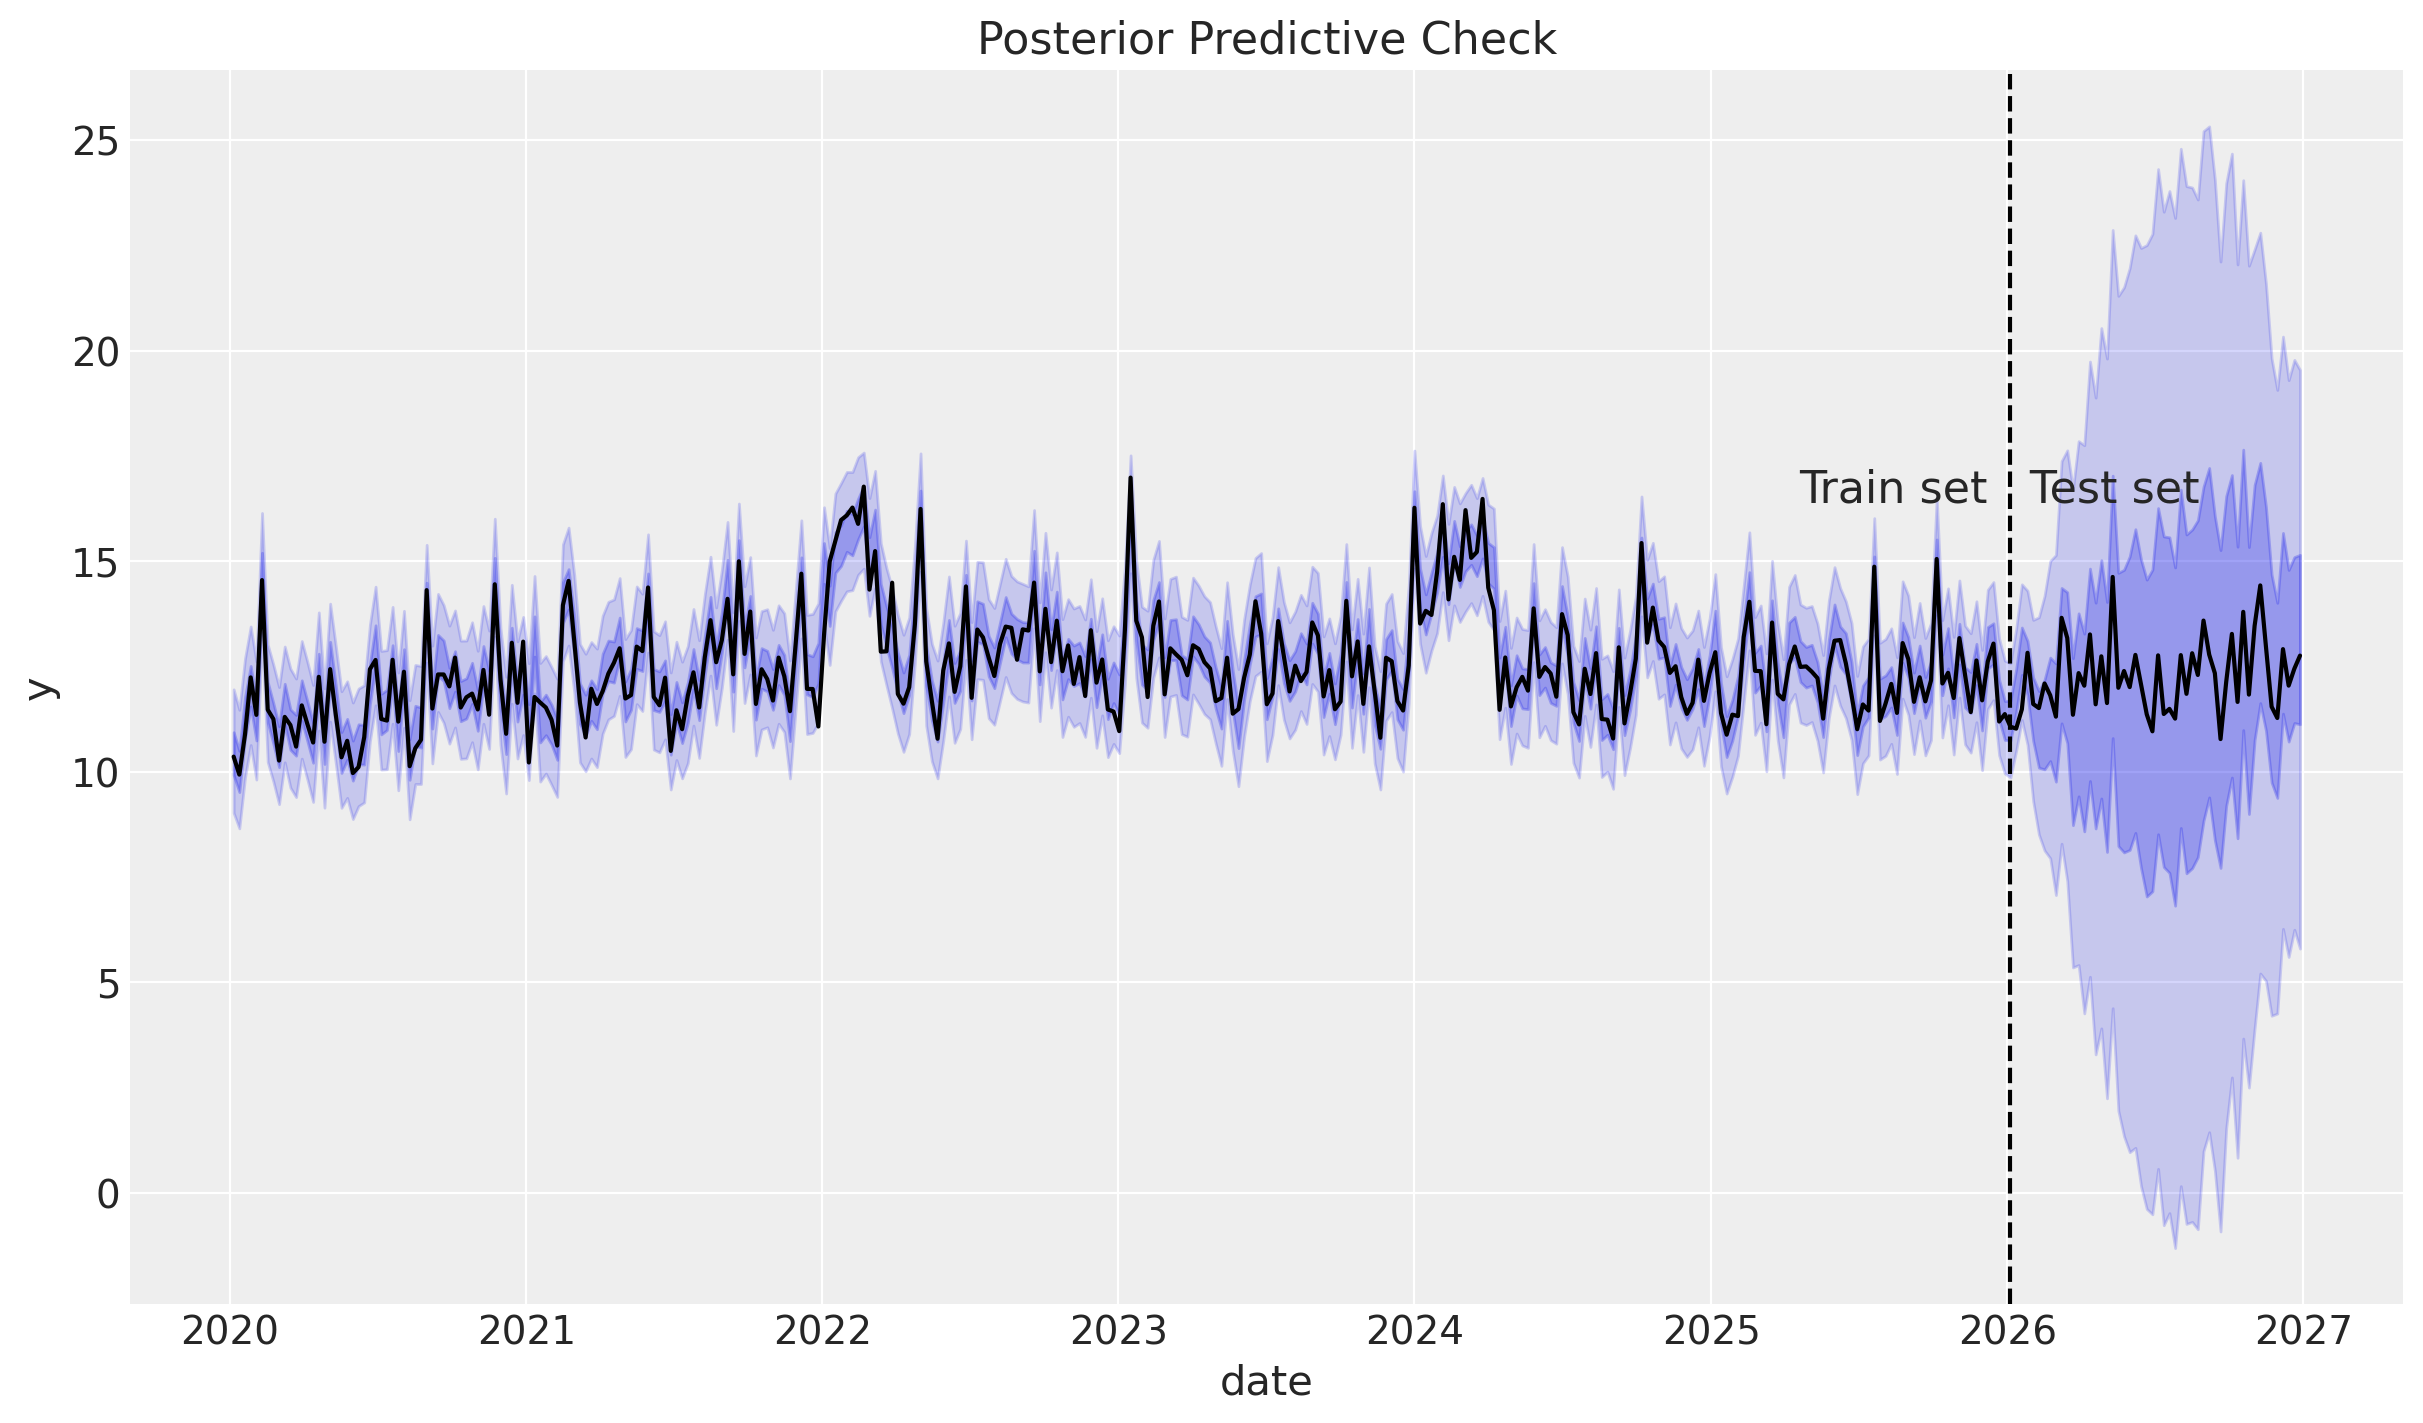

In [53]:
plot_posterior_predictive(mmm_events_short_ls, DATA["target_events"])

intercept_base: 4.601167635667814


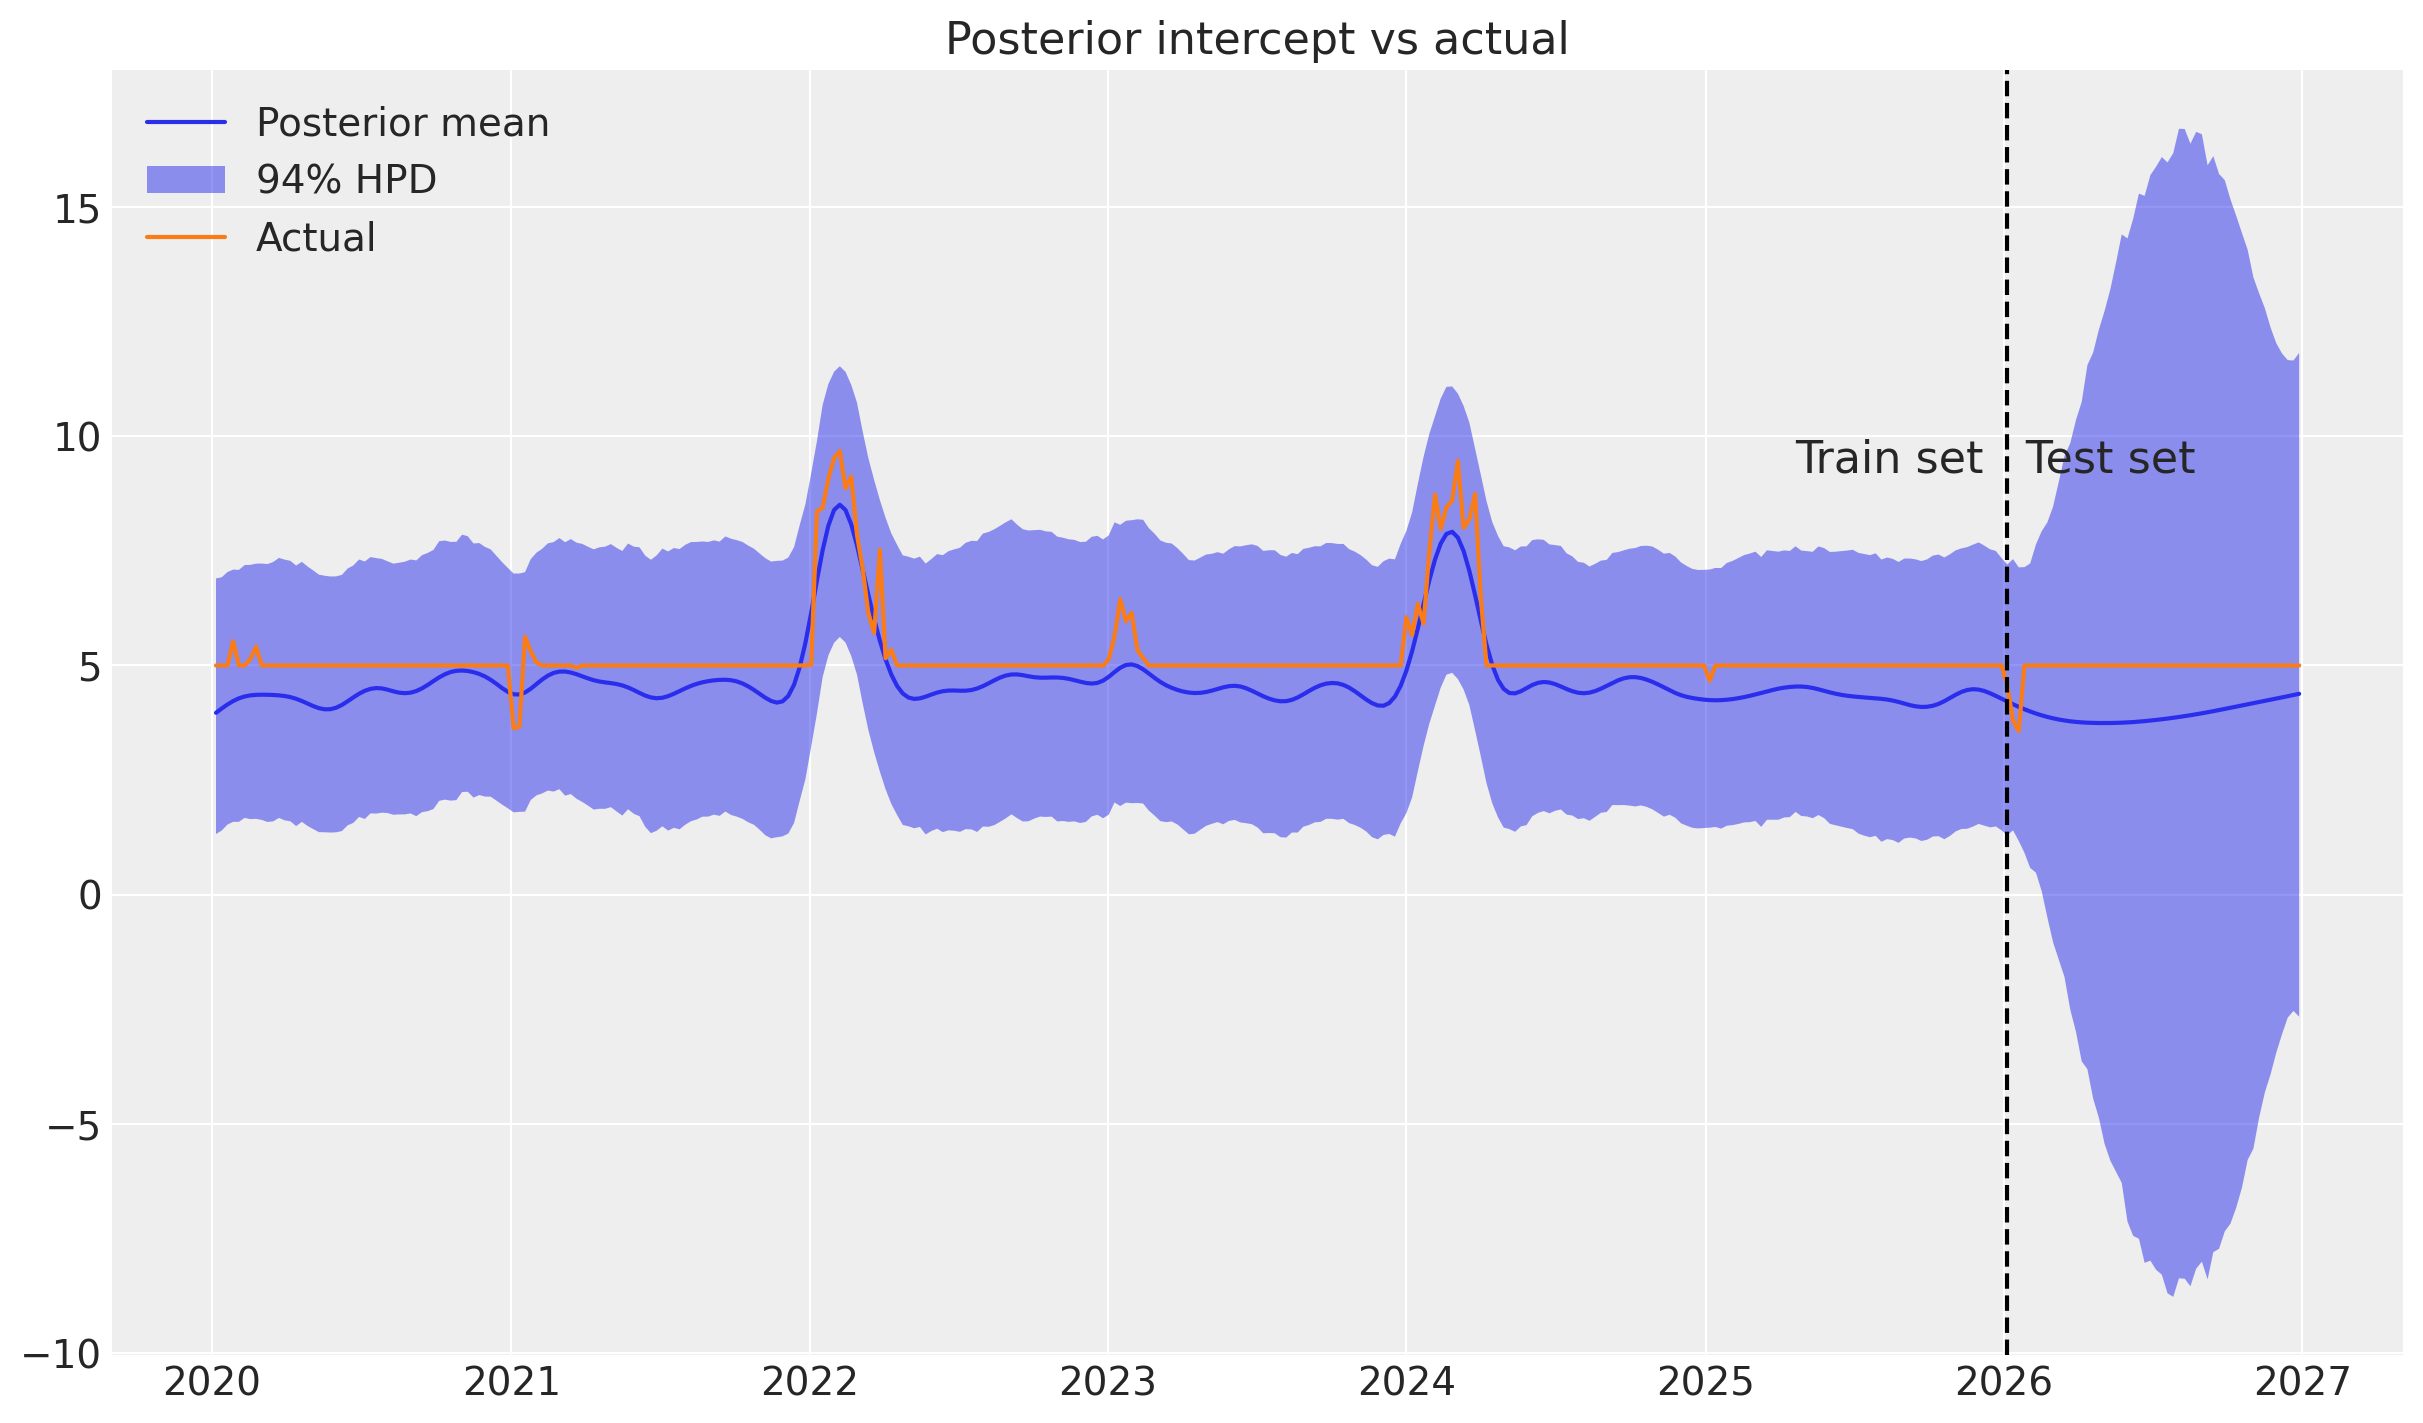

In [54]:
print_intercept_base(mmm_events_short_ls)
plot_intercept_posterior_predictive(mmm_events_short_ls, synthetic_intercept_events)

As anticipated, the time-varying intercept now models the events better, and at the right scale! Notice how, lowering the length-scale prior mean from the default two  years to one year makes the series more *squiggly*. Lowering the length-scale prior mean, we should also expect greater uncertainty around future-predictions. While the very-small events are not captured well, this may be remedied with a more complex covaraince function supplied through the `model_config`, although these avents are likely below the minimal detectable effect size in this example.

## Conclusion

In this notebook, we have demonstrated how to use a time-varying parameter in a marketing mix model using pymc-marketing. We have shown how the model can capture yearly seasonality, upward trending sales, and random events. The model performs well in-sample in all cases but has characteristic flaws when predicting out-of-sample for the first two examples.

**What do we learn from this?**

Gaussian Processes (GPs) are great at capturing patterns that are not easy/possible to extrapolate, and in turn, they cannot well extrapolate simple patterns like seasonality or increasing trends. For cases like these, a Fourier basis or similar might be more appropriate. However, for explaining temporal variance that no other model component can account for—like the impact of an unexpected event—a GP is a great tool.

**When should I use a time-varying parameter?**

If you have good reason to believe that the effect of your marketing mix is not constant over time, due to factors other than seasonality and constant growth, then a time-varying parameter is a good choice. This could be due to changing trends, external events, etc. It is therefore meaningful to use the time-varying intercept together with a Fourier basis if you have seasonality in your sales, or a linear trend if you have growth.

**How should I parameterize my time-varying component?**

We have defined some sensible defaults, and in most cases, these will be adequate. But if you have unexplained variance in your sales that occur on short time scales, you may—as in the example above—experiment with lowering the length-scale prior mean. If you need greater fidelity in the frequencies that the GP can capture, and can live with longer sampling times, you can also increase the number of basis functions `model_config['intercept_tvp_kwargs']['m']` from 200 (default) to a higher number. Finally, if you believe you have events affecting your sales on, say, two separate time scales, you can supply a new covariance function through `model_config['intercept_tvp_kwargs']['cov_func']`, which is the sum of two independently defined covariance functions—each with a length-scale prior mean that matches the given time scales you expect in your data.